In [1]:
#Module imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import re 
import seaborn as sns 
import os 

In [2]:
##Preprocessing##
#Read bpm and mcseed information 
formatted_dir = "formatted_input"
bpm_path = "{0}/19isolates_BPM.csv".format(formatted_dir)
mcseed_path = "{0}/19isolates_mcseed_pathwaycomplete.csv".format(formatted_dir)
bpm_df = pd.read_csv(bpm_path)
mcseed_df = pd.read_csv(mcseed_path)
#Process GO annotations from semicolon separated string into list of entries for columns Functional Pathway and Phenotype
for col in ["Functional pathway", "Phenotype"]:
    mcseed_df.loc[:,col] = mcseed_df.loc[:,col].str.split(";")
#     mcseed_df.loc[:,col] = [entry.strip() for entry in mcseed_df.loc[:,col]]
#Set indices: BPM -> Isolate name; mcseed -> Locus tag; TPM -> target_id (locus)
bpm_df.set_index("Isolate name",inplace=True)
bpm_df = bpm_df.transpose().drop(index="# functions")
mcseed_df.set_index("Locus tag",inplace=True)
mcseed_df.loc[:,"Phenotype"] = mcseed_df["Phenotype"].apply(lambda phts_list: [pht.strip() for pht in phts_list])

#Make helper dictionaries mapping strain full names to abbreviations and 
#shortened abbreviations (first 3 char) to full names
STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Blu","Rob","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Lru","Mmu","Pco","Pst",
                  "Rgn","Rto","Sga","Spa"]
STRAIN_TAGS = dict(zip(bpm_df.columns,STRAIN_ABBREVS))
SHORT_ABBREVS = [abbrev[:3] for abbrev in STRAIN_ABBREVS]
STRAIN_ABBREV_TO_FULL = dict(zip(SHORT_ABBREVS, bpm_df.columns))

for strain in STRAIN_TAGS:
    strain_abbrev = STRAIN_TAGS[strain]
    if not (strain == "Blautia obeum Bg7063_SSTS2015" and strain_abbrev == "Rob"): 
        assert(strain[0] == strain_abbrev[0])

dropped_strains = ["Bifidobacterium longum infantis 40721_2D9_SN","Prevotella copri PS_131_S11","Prevotella stercorea DSM_18206"]
bpm_df_16strains = bpm_df.loc[:,~bpm_df.columns.isin(dropped_strains)]
        
#BPM Summary statistics 
print("BPM=1 pathways by strain")
# print(bpm_df.sum())
# print("Total BPM=1 pathways: {0}".format(bpm_df.sum().sum()))
print(bpm_df_16strains.sum())
print("Total BPM=1 pathways: {0}".format(bpm_df_16strains.sum().sum()))


BPM=1 pathways by strain
Isolate name
Bifidobacterium breve Bgsng463_m5_93           46
Bifidobacterium catenulatum Bgsng468_m22_84    44
Blautia luti Bg7063                            53
Blautia obeum Bg7063_SSTS2015                  53
Dorea formicigenerans Bg7063                   43
Dorea longicatena Bg7063                       45
Enterococcus_avium_Bang_SAM2_39_S1             57
Escherichia coli PS_131_S11                    77
Faecalibacterium prausnitzii Bg7063            43
Lactococcus garvieae Bang155_08_4B6_JG2017     32
Ligilactobacillus ruminis ATCC_25644           33
Mitsuokella multacida DSM_20544                45
Ruminococcus gnavus M8243_3A11_TMS_2014        63
Ruminococcus torques Bg7063                    50
Streptococcus gallolyticus PS_064_S07          42
Streptococcus pasteriuanus Bang_SAM2_39_S1     47
dtype: int64
Total BPM=1 pathways: 773


In [3]:
def vc_strain_locus_tag(expr_df,mcseed_df):
    """Returns a DataFrame indexed on locus tags for each strain, containing columns: 
        "Filtered Loci" - number of loci corresponding to that locus tag (ie loci per strain)
        "Strain" - full strain name corresponding to locus tag 
        :param pd.DataFrame expr_df: DataFrame indexed by ORFs containing (transformed) expression data, columns
        are samples 
        :param pd.DataFrame mcseed_df: DataFrame containing mcSEED annotations for loci, not necessarily for 
        all loci in expr_df 
    """
    vc_by_strain_locus_tag = expr_df.index.str.extract(r'(\w+)_\d+',expand=False).value_counts()
#     vc_by_strain_locus_tag.drop("ROSSTS7063_a2",inplace=True) #2nd3rd_trial specific error 
    locus_tag_strains = [mcseed_df.loc[mcseed_df.index.str.contains(lt),"Isolate name"].values[0] 
                             for lt in vc_by_strain_locus_tag.index] #if lt != "ROSSTS7063_a2"]
    locus_vc_df = pd.DataFrame(index=vc_by_strain_locus_tag.index,columns=["Filtered Loci","Strain"])
    locus_vc_df.loc[:,"Filtered Loci"] = vc_by_strain_locus_tag
    locus_vc_df.loc[:,"Strain"] = locus_tag_strains
    return locus_vc_df

In [4]:
DATA_FILTERING = "edgeR"
# DATA_FILTERING = "tpm_prev"
if DATA_FILTERING == "tpm_prev":
    # transformed_data_dir = "formatted_output/4th_trial/transformed_abundance_corrected/thr3_prev0.3_cecal_nonprevotella"
#     transformed_data_dir = "formatted_output/4th_trial/transformed_abundance_corrected/thr3_prev0.25_cecal_nonprevotella_E7"
#     transformed_data_dir = "formatted_output/4th_trial/transformed_abundance_corrected/thr3_prev0.25_cecal_nonprevotella_E6"
    transformed_data_dir = "formatted_output/4th_trial/transformed_abundance_corrected/thr3_prev0.25_cecal_nonprevotella_E6_floor"
    # transformed_data_dir = "formatted_output/4th_trial/transformed/thr3_prev0.3_cecal_nonprevotella" #non-abundance corrected
    trial_dir, transformed_subdir, param_str =  re.match(r"formatted_output\/([\w_\.]+)\/([\w_\.]+)\/([\w_\.]+)",
                                                         transformed_data_dir).groups()
    figures_dir = "figures/{0}/{1}/heatmap".format(trial_dir,param_str)
    if not os.path.exists(figures_dir):
        os.makedirs(figures_dir)

    filt_tpm_fpath = "{0}/filt_merged_tpm.csv".format(transformed_data_dir)
    filt_vst_fpath = "{0}/filt_merged_vst.csv".format(transformed_data_dir)
    filt_log_fpath = "{0}/filt_merged_log.csv".format(transformed_data_dir)
    filt_rlog_fpath = "{0}/filt_merged_rlog.csv".format(transformed_data_dir)
    filt_tpm_df = pd.read_csv(filt_tpm_fpath,index_col=0)
    filt_vst_df = pd.read_csv(filt_vst_fpath,index_col=0)
    filt_log_df = pd.read_csv(filt_log_fpath,index_col=0)
    filt_rlog_df = pd.read_csv(filt_rlog_fpath,index_col=0)

    DATASET = "rlog"
    if DATASET == "rlog":
        filt_expr_df = filt_rlog_df
        agg_method = "mean"
    elif DATASET == "log":
        filt_expr_df = filt_log_df
        agg_method = "nonzero_mean"
    elif DATASET == "vst":
        filt_expr_df = filt_vst_df
        agg_method = "nonzero_mean"

    locus_vc_df = vc_strain_locus_tag(filt_expr_df,mcseed_df)
    print("Total TPM filtered loci: {0}".format(len(filt_expr_df)))

    # bpm_filt_dir = "formatted_output/4th_trial/bpm_filtered/{0}".format(param_str)
    bpm_filt_dir = "formatted_output/4th_trial/bpm_filtered_abundance_corrected/{0}".format(param_str)
elif DATA_FILTERING == "edgeR":
    ###EdgeR Filtering Data###
    transformed_data_dir = "formatted_output/4th_trial/edgeR_filtered"
    trial_dir, param_str =  re.match(r"formatted_output\/([\w_\.]+)\/([\w_\.]+)",
                                                         transformed_data_dir).groups()
    figures_dir = "figures/{0}/{1}/heatmap".format(trial_dir,param_str)
    if not os.path.exists(figures_dir):
        os.makedirs(figures_dir)

    filt_rlog_fpath = "{0}/edgeR_filt_rlog.csv".format(transformed_data_dir)
    filt_rlog_df = pd.read_csv(filt_rlog_fpath,index_col=0)

    DATASET = "rlog"
    if DATASET == "rlog":
        filt_expr_df = filt_rlog_df
        agg_method = "mean"

    locus_vc_df = vc_strain_locus_tag(filt_expr_df,mcseed_df)
    print("Total filtered loci: {0}".format(len(filt_expr_df)))

    bpm_filt_dir = "formatted_output/4th_trial/{0}".format(param_str)
if not os.path.exists(bpm_filt_dir):
    os.makedirs(bpm_filt_dir)

Total filtered loci: 22387


In [5]:
#Check phenotype mapping for strains 
low_filt_count = locus_vc_df.loc[locus_vc_df["Filtered Loci"] < 100,"Strain"]
all_filt_counts = locus_vc_df.loc[:,"Strain"]
#for loc_tag, strain in low_filt_count.iteritems():
mcseed_counts_df = locus_vc_df.copy()
for loc_tag, strain in all_filt_counts.iteritems():
    filt_locs = filt_expr_df.loc[filt_expr_df.index.str.contains(loc_tag),:]
#     display(filt_locs)
    assert(len(filt_locs) == locus_vc_df.loc[loc_tag,"Filtered Loci"])
    filt_locs_idx = filt_locs.index
    mcseed_present = 0 
    mcseed_absent = 0 
    for locus in filt_locs_idx:
        try: 
            mcseed_row = mcseed_df.loc[locus,:]
            mcseed_present += 1
        except KeyError as e:
            mcseed_absent += 1
    mcseed_counts_df.loc[loc_tag,"mcseed_present"] = mcseed_present
    mcseed_counts_df.loc[loc_tag,"mcseed_absent"] = mcseed_absent
#     print("mcseed Present: {0}; mcseed Absent: {1}".format(mcseed_present,mcseed_absent))
    assert(mcseed_present+mcseed_absent == len(filt_locs))
mcseed_counts_df.loc[:,"mcseed_present"] = mcseed_counts_df.loc[:,"mcseed_present"].astype(int)
mcseed_counts_df.loc[:,"mcseed_absent"] = mcseed_counts_df.loc[:,"mcseed_absent"].astype(int)
display(mcseed_counts_df)

,Filtered Loci,Strain,mcseed_present,mcseed_absent
HMLHAAEP,4560,Escherichia coli PS_131_S11,506,4054
GJBELKAJ,3333,Ruminococcus gnavus M8243_3A11_TMS_2014,478,2855
AKLJOBCP,2587,Enterococcus_avium_Bang_SAM2_39_S1,405,2182
OOAPABDJ,2457,Dorea longicatena Bg7063,287,2170
HIAFFLEM,2030,Blautia obeum Bg7063_SSTS2015,323,1707
LDOIJNDB,1520,Streptococcus pasteriuanus Bang_SAM2_39_S1,242,1278
NNMNEBCK,1409,Bifidobacterium catenulatum Bgsng468_m22_84,224,1185
ONMCJBAG,1265,Mitsuokella multacida DSM_20544,152,1113
ANCJAENF,1069,Bifidobacterium breve Bgsng463_m5_93,189,880
CGCJBKJN,960,Ruminococcus torques Bg7063,167,793


In [6]:
#Function version of sample Pht x strainate DataFrames 
def per_sample_pht_aggregation(expr_df, bpm_df, mcseed_df,agg_method="nonzero_mean",verbose=False):
    """Generates a dictionary mapping sample names to DataFrame objects where index = phenotypes, 
        columns = strainates, and individual values are pathway aggregated expression (currently implemented
        as mean of non-minimum values ~ i.e. non zero transcript (vst or log transformed) expression)
        expr_df: DataFrame with index of gene loci and columns of samples. Can be tpm/prevalence filtered
                 as well as tpm, vst, or log transformed
        bpm_df: DataFrame with index of phenotypes and columns of strainates 
        mcseed_df: DataFrame with index of locus tags and containing mcSEED annotation information for those loci,
        including the column Phenotype which must contain lists of Pht abbreviations corresponding to the phenotypes
        in bpm_df. 
        agg_methods: {nonzero_mean, ...}; nonzero_mean - drops minimum expression value (ie 0 or vst/log 
        transformed 0s) before aggregating phenotype expression by mean 
    """
    sample_pht_expr_dfs = {}
    for sample in expr_df:
        sample_pht_expr_dfs[sample] = bpm_df.copy()
    min_expr = expr_df.values.min()
    if verbose: 
        print("Min expression value: {0}".format(min_expr))
    
    for strain in bpm_df:
        bpm_expr_col = bpm_df.loc[:,strain]
        strain_mcseed_df = mcseed_df.loc[mcseed_df["Isolate name"]==strain]
        if verbose: 
            print("Isolate: {1} \nComplete Pathways: {0}".format(sum(bpm_expr_col),strain))
        for pht,entry in bpm_expr_col.iteritems():
            if entry == 1:
                pht_strain_mcseed_df = strain_mcseed_df.loc[strain_mcseed_df["Phenotype"].apply(lambda phts_list:pht in phts_list)]
                try:
                    pht_strain_expr_df = expr_df.loc[pht_strain_mcseed_df.index[pht_strain_mcseed_df.index.isin(expr_df.index)]]
                    if agg_method == "nonzero_mean":
                        ##Include this line for dropping 0s (or transformed 0s) from phenotype averages##
                        pht_strain_expr_df = pht_strain_expr_df.replace(min_expr,np.nan)
                    elif agg_method == "mean":
                        pass #Retain (transformed) 0s in phenotype aggregation; use this option if using rlog 
                        #data since rlog does not stably transform all 0 expressions to one min value
                    for sample in pht_strain_expr_df:
                        sample_pht_expr_df = sample_pht_expr_dfs[sample]
                        pht_strain_tpm = pht_strain_expr_df[sample]
#                         pht_agg = 1 #Same as bpm_df 
                        pht_agg = pht_strain_tpm.mean()
                        sample_pht_expr_df.loc[pht,strain] = pht_agg
                except KeyError as e:
                    #Occurs when none of pht loci are in expr_df; aggregated expression = np.nan
                    pht_agg = np.nan
                    for sample in expr_df: 
                        sample_pht_expr_df = sample_pht_expr_dfs[sample]
                        sample_pht_expr_df.loc[pht,strain] = pht_agg
    return sample_pht_expr_dfs

#TODOs: 1. Function for pathway aggregated SVD data formatting
def pht_aggregation_bpm1(expr_df, bpm_df, mcseed_df,agg_method="nonzero_mean",
                         verbose=False,reorder_columns="cecal_1C2B",pathway_minimum_fill="na"):
    """Generates a single DataFrame objects where index = phenotypes for which BPM=1 grouped by taxa, 
        columns = strainates, and individual values are pathway aggregated expression (currently implemented
        as mean of non-minimum values ~ i.e. non zero transcript (vst or log transformed) expression)
        expr_df: DataFrame with index of gene loci and columns of samples. Can be tpm/prevalence filtered
                 as well as tpm, vst, or log transformed
        bpm_df: DataFrame with index of phenotypes and columns of strainates 
        mcseed_df: DataFrame with index of locus tags and containing mcSEED annotation information for those loci,
        including the column Phenotype which must contain lists of Pht abbreviations corresponding to the phenotypes
        in bpm_df. 
        agg_methods: {"nonzero_mean","mean"}; nonzero_mean - drops minimum expression value (ie 0 or vst/log 
        transformed 0s) before aggregating phenotype expression by mean; mean - retain minimum expression value 
        in aggregated phenotypes 
        pathway_minimum_fill: {"min","na"}: if an entire phenotype has aggregated expression equal to min_expr 
        (ie no loci in phenotype are expressed), determines fill value. Use min for subsequent SVD, na for 
        aggregated phenotype expression visualization. 
        
    """
    all_pht_df = pd.DataFrame(columns=expr_df.columns)
    min_expr = expr_df.values.min()
    print("Min expression value: {0}".format(min_expr))
    
    for strain in bpm_df:
        bpm_expr_col = bpm_df.loc[:,strain]
        strain_mcseed_df = mcseed_df.loc[mcseed_df["Isolate name"]==strain]
        if verbose:
            print("Isolate: {1} \nComplete Pathways: {0}".format(sum(bpm_expr_col),strain))
        bpm1_entries = bpm_expr_col[bpm_expr_col==1]
        strain_phts = ["{0}_{1}".format(STRAIN_TAGS[strain],pht) for pht in bpm1_entries.index]
        strain_pht_agg_df = pd.DataFrame(index=strain_phts,columns=expr_df.columns)
        for pht in bpm1_entries.index:
            pht_strain_mcseed_df = strain_mcseed_df.loc[strain_mcseed_df["Phenotype"].apply(lambda phts_list:pht in phts_list)]
            
            try:
                pht_strain_expr_df = expr_df.loc[pht_strain_mcseed_df.index[pht_strain_mcseed_df.index.isin(expr_df.index)]]
                if strain =="Blautia obeum Bg7063_SSTS2015" and pht == "Xyl":
                    display(pht_strain_expr_df)
                if agg_method == "nonzero_mean":
                    ##Include this line for dropping 0s (or transformed 0s) from phenotype averages##
                    pht_strain_expr_df = pht_strain_expr_df.replace(min_expr,np.nan)
                elif agg_method == "mean":
                    pass #Retain (transformed) 0s in phenotype aggregation 
                strain_pht_str = "{0}_{1}".format(STRAIN_TAGS[strain],pht)
                sample_pht_means = pht_strain_expr_df.mean(axis=0)
                strain_pht_agg_df.loc[strain_pht_str,:] = sample_pht_means
            except KeyError as e:
                #Occurs when none of pht loci are in expr_df; aggregated expression = np.nan for pht 
                pht_agg = np.nan
                strain_pht_agg_df.loc[strain_pht_str,:] = pht_agg
        all_pht_df = pd.concat([all_pht_df,strain_pht_agg_df])
    #column reordering 
    if reorder_columns:
        cols_1C_arr, cols_2B_arr = [all_pht_df.columns.str.contains(tag) for tag in ["1C","2B"]] #boolean arrays 
        cols_1C, cols_2B = [all_pht_df.columns[cols] for cols in [cols_1C_arr,cols_2B_arr]]#filtered column lists 
        cols_1C_cecal_arr, cols_1C_ileal_arr = [cols_1C.str.contains(tag) for tag in ["cecal","ileal"]] #boolean_arrays
        cols_1C_cecal, cols_1C_ileal = [cols_1C[cols_1C_cecal_arr],cols_1C[cols_1C_ileal_arr]] #filtered columns
        cols_2B_cecal_arr, cols_2B_ileal_arr = [cols_2B.str.contains(tag) for tag in ["cecal","ileal"]] #boolean arrays
        cols_2B_cecal, cols_2B_ileal = [cols_2B[cols_2B_cecal_arr],cols_2B[cols_2B_ileal_arr]]
        if reorder_columns=="cecal_1C2B":
            reordered_cols = pd.Index(list(cols_1C_cecal)+list(cols_2B_cecal)+list(cols_1C_ileal)+list(cols_2B_ileal))
        all_pht_df = all_pht_df.loc[:,reordered_cols].astype("float")
    #Minimum aggregated phenotype value handling - retain min values for PCA/SVD or na for heatmap 
    #visualization purposes
    if pathway_minimum_fill == "na":
        all_pht_df.replace(min_expr,np.nan,inplace=True)
        if verbose: 
            print("Replacing minimum expression value ({0}) for aggregated phenotypes with np.nan".format(min_expr))
    elif pathway_minimum_fill == "min":
        all_pht_df.replace(np.nan,min_expr,inplace=True)
        if verbose:
            print("Replacing np.nan aggregated phenotypes with minimum expression value: {0}".format(min_expr))
    return all_pht_df
#TODO: 2. Function for BPM=1 filtering of expr_df for individual transcript SVD
def bpm_filter_expr_data(expr_df,bpm_df,mcseed_df,verbose=False,reorder_columns="cecal_1C2B"):
    """Return a filtered version of expr_df in original row order from expr_df containing only loci 
    which map to a complete phenotype (BPM=1)
    expr_df: DataFrame with index of gene loci and columns of samples. Can be tpm/prevalence filtered
                 as well as tpm, vst, or log transformed
    bpm_df: DataFrame with index of phenotypes and columns of strainates 
    mcseed_df: DataFrame with index of locus tags and containing mcSEED annotation information for those loci,
        including the column Phenotype which must contain lists of Pht abbreviations corresponding to the phenotypes
        in bpm_df. 
    """
    bpm_filt_expr_df = pd.DataFrame(columns=expr_df.columns)
    for strain in bpm_df:
        bpm_expr_col = bpm_df.loc[:,strain]
        strain_mcseed_df = mcseed_df.loc[mcseed_df["Isolate name"]==strain]
        if verbose:
            print("Isolate: {1} \nComplete Pathways: {0}".format(sum(bpm_expr_col),strain))
        bpm1_entries = bpm_expr_col[bpm_expr_col==1]
        for pht in bpm1_entries.index:
            pht_strain_mcseed_df = strain_mcseed_df.loc[strain_mcseed_df["Phenotype"].apply(lambda phts_list:pht in phts_list)]
            try:
                pht_strain_expr_df = expr_df.loc[pht_strain_mcseed_df.index[pht_strain_mcseed_df.index.isin(expr_df.index)]]
                bpm_filt_expr_df = pd.concat([bpm_filt_expr_df,pht_strain_expr_df])
            except KeyError as e:
                pass
    #column reordering 
    if reorder_columns:
        cols_1C_arr, cols_2B_arr = [bpm_filt_expr_df.columns.str.contains(tag) for tag in ["1C","2B"]] #boolean arrays 
        cols_1C, cols_2B = [bpm_filt_expr_df.columns[cols] for cols in [cols_1C_arr,cols_2B_arr]]#filtered column lists 
        cols_1C_cecal_arr, cols_1C_ileal_arr = [cols_1C.str.contains(tag) for tag in ["cecal","ileal"]] #boolean_arrays
        cols_1C_cecal, cols_1C_ileal = [cols_1C[cols_1C_cecal_arr],cols_1C[cols_1C_ileal_arr]] #filtered columns
        cols_2B_cecal_arr, cols_2B_ileal_arr = [cols_2B.str.contains(tag) for tag in ["cecal","ileal"]] #boolean arrays
        cols_2B_cecal, cols_2B_ileal = [cols_2B[cols_2B_cecal_arr],cols_2B[cols_2B_ileal_arr]]
        n_1C_cecal, n_1C_ileal, n_2B_cecal, n_2B_ileal = [len(cols) for cols in [cols_1C_cecal,cols_1C_ileal,
                                                                                cols_2B_cecal,cols_2B_ileal]]
        if reorder_columns=="cecal_1C2B":
            reordered_cols = pd.Index(list(cols_1C_cecal)+list(cols_2B_cecal)+list(cols_1C_ileal)+list(cols_2B_ileal))
        bpm_filt_expr_df = bpm_filt_expr_df.loc[:,reordered_cols].astype("float")
    return bpm_filt_expr_df

aggregation method: mean
Min expression value: -2.97762143357795


,Pup_1.cecal_contents_53_1C_Pup_1,Pup_2.cecal_contents_53_1C_Pup_2,Pup_3.cecal_contents_53_1C_Pup_3,Pup_4.cecal_contents_53_1C_Pup_4,Pup_5.cecal_contents_53_1C_Pup_5,Pup_6.cecal_contents_53_1C_Pup_6,Pup_7.cecal_contents_53_1C_Pup_7,Pup_8.cecal_contents_53_1C_Pup_8,Pup_1.cecal_contents_54_2B_Pup_1,Pup_2.cecal_contents_54_2B_Pup_2,Pup_3.cecal_contents_54_2B_Pup_3,Pup_4.cecal_contents_54_2B_Pup_4,Pup_5.cecal_contents_54_2B_Pup_5,Pup_6.cecal_contents_54_2B_Pup_6,Pup_7.cecal_contents_54_2B_Pup_7
Locus tag,,,,,,,,,,,,,,,
HIAFFLEM_01075,7.248633,6.965733,6.969756,6.347331,6.189161,6.310266,7.198007,7.042030,0.478521,0.238120,0.254426,-0.280545,0.727089,0.469638,0.131544
HIAFFLEM_01096,7.362768,7.016233,7.601560,6.841716,6.618802,6.693936,7.493456,7.019437,0.729376,0.510778,0.525467,0.056561,0.959489,0.721225,0.415316
HIAFFLEM_01102,5.574076,4.990438,4.998438,5.058062,4.056329,4.082069,5.331376,4.756320,-0.687311,-1.004403,-0.982276,-1.772152,-0.367914,-0.698702,-1.151523
HIAFFLEM_01301,10.936498,10.634166,10.942423,10.160354,10.123530,9.197001,10.970434,10.198956,4.436833,4.414952,4.416242,4.385149,4.467129,4.435906,4.407138
HIAFFLEM_01302,11.423465,11.034747,11.347855,10.610990,10.481934,9.773466,11.295597,10.602194,5.337520,5.326139,5.326803,5.311000,8.206036,5.337033,5.322129
HIAFFLEM_01303,13.058635,12.859483,13.221187,12.552105,12.464402,12.105446,13.411839,12.724339,9.115138,9.114673,10.213332,11.780971,10.681536,9.115118,9.904517
HIAFFLEM_01966,4.649399,4.599156,3.264389,3.694484,4.428110,-0.037721,2.386214,3.950116,-1.141791,-1.494338,-1.470016,-2.292421,-0.787379,-1.154617,-1.655120
HIAFFLEM_02424,10.253823,9.534462,10.358256,9.333663,8.615550,9.223833,9.354356,9.635048,3.532273,3.491708,3.494138,3.434060,3.586325,3.530583,3.476876
HIAFFLEM_02425,9.037790,8.225651,9.087048,8.020485,7.164087,7.697556,7.870167,8.350788,2.056950,1.951932,1.958543,1.779399,2.182513,2.052781,1.910555


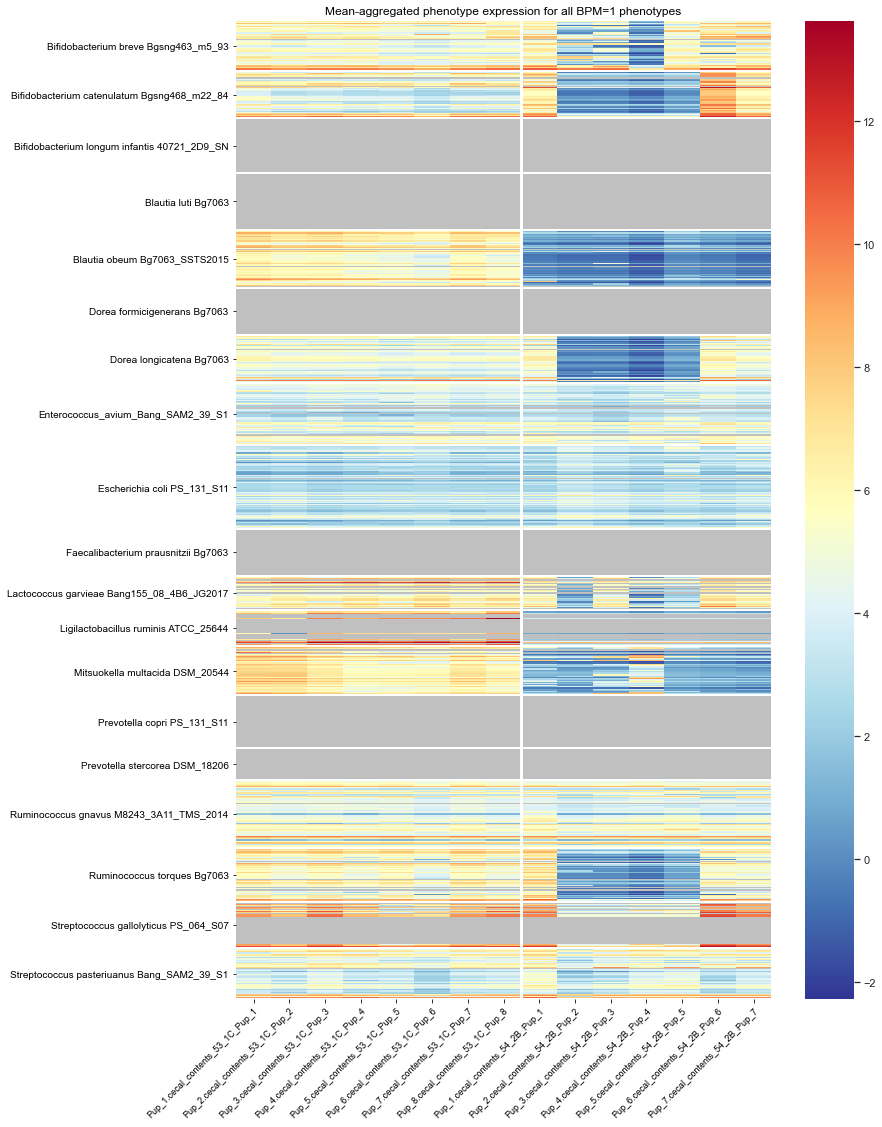

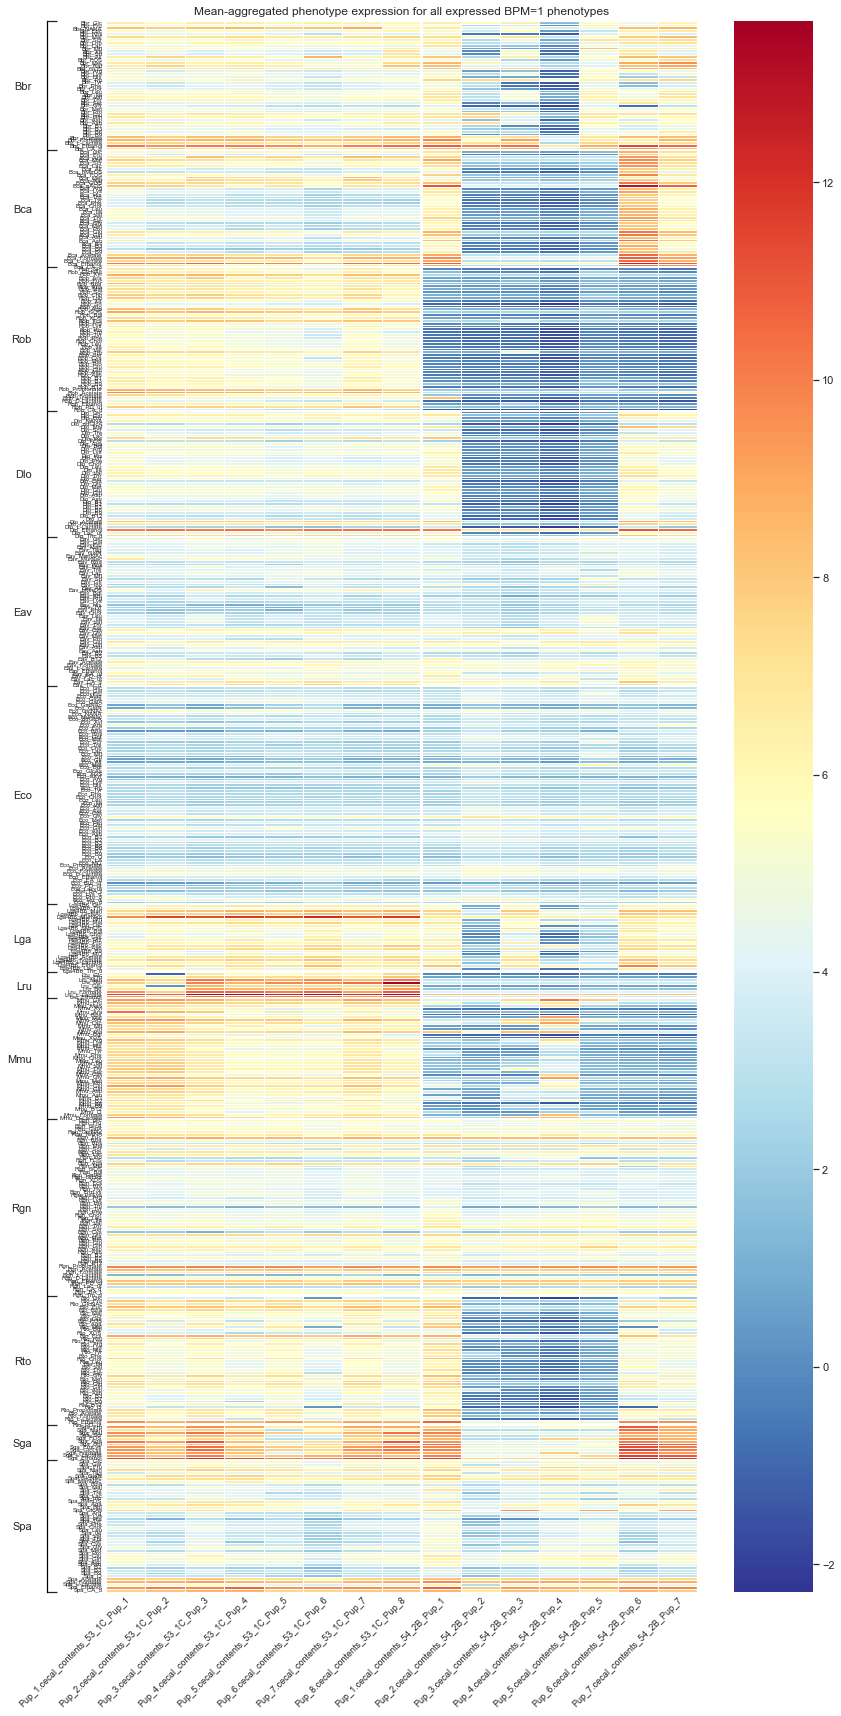

In [7]:
import matplotlib.ticker as ticker
from mpl_toolkits.axisartist.parasite_axes import SubplotHost

##log version##
# all_pht_df = pht_aggregation_bpm1(filt_expr_df,bpm_df,mcseed_df,agg_method=agg_method,
#                                  pathway_minimum_fill="na")
##rlog version##
print("aggregation method: {0}".format(agg_method))
all_pht_df = pht_aggregation_bpm1(filt_expr_df,bpm_df,mcseed_df,agg_method=agg_method,
                                 pathway_minimum_fill="na")

cols_1C_arr, cols_2A_arr = [all_pht_df.columns.str.contains(tag) for tag in ["1C","2A"]] #boolean arrays 
cols_1C, cols_2A = [all_pht_df.columns[cols] for cols in [cols_1C_arr,cols_2A_arr]]#filtered column lists 
cols_1C_cecal_arr, cols_1C_ileal_arr = [cols_1C.str.contains(tag) for tag in ["cecal","ileal"]] #boolean_arrays
cols_1C_cecal, cols_1C_ileal = [cols_1C[cols_1C_cecal_arr],cols_1C[cols_1C_ileal_arr]] #filtered columns
cols_2A_cecal_arr, cols_2A_ileal_arr = [cols_2A.str.contains(tag) for tag in ["cecal","ileal"]] #boolean arrays
cols_2A_cecal, cols_2A_ileal = [cols_2A[cols_2A_cecal_arr],cols_2A[cols_2A_ileal_arr]]
n_1C_cecal, n_1C_ileal, n_2A_cecal, n_2A_ileal = [len(cols) for cols in [cols_1C_cecal,cols_1C_ileal,
                                                                        cols_2A_cecal,cols_2A_ileal]]
#Uncondensed heatmap (all BPM=1 pathways without dropping those with missing expression data)
plot_uncondensed_heatmap = True
if plot_uncondensed_heatmap:
    fig = plt.figure(figsize=(12,18))
    fig.tight_layout()
    plt.title("Mean-aggregated phenotype expression for all BPM=1 phenotypes",fontsize=12)
    sns.set(font_scale=1.0)
    g = sns.heatmap(all_pht_df,cmap="RdYlBu_r",xticklabels=True,yticklabels=False)
    strain_bpm_complete_counts, total_bpm1 = bpm_df.sum(), bpm_df.sum().sum()
    strain_hline_pos,strain_label_pos = [],[]
    for strain,bpm_count in strain_bpm_complete_counts.iteritems():
        #position is top of block of strain phenotypes; top of heatmap is position 0  
        strain_hline_pos.append((strain_bpm_complete_counts.loc[:strain].sum()))
        strain_label_pos.append((strain_bpm_complete_counts.loc[:strain].sum())-bpm_count/2)
    cecal_ileal_vline = n_1C_cecal + n_2A_cecal
    g.vlines([cecal_ileal_vline],*g.get_ylim(),color="white",linewidth=3)
    arm_vlines = [n_1C_cecal,n_1C_cecal+n_1C_ileal+n_2A_cecal]
    g.vlines(arm_vlines,*g.get_ylim(),color="white",linewidth=2)
    g.hlines(strain_hline_pos,*g.get_xlim(),color="white",linewidth=2)

    g.set_yticks(strain_label_pos)
    g.set_yticklabels(bpm_df.columns)
    g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right', rotation_mode='anchor',fontsize=9)
    g.set_facecolor("#C0C0C0")
    plt.savefig("{0}/all_pht_{1}_heatmap.pdf".format(figures_dir,DATASET), dpi=200, facecolor='w',bbox_inches="tight")

#Condensed heatmap (drop pathways missing expression data)
# from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(1,1, figsize=(12,24))
plt.subplots_adjust(right=0.75)

ax1.set_title("Mean-aggregated phenotype expression for all expressed BPM=1 phenotypes",fontsize=12)
sns.set(font_scale=1.0)
condensed_allpht_df = all_pht_df.dropna(axis=0,how="all")
sns.heatmap(condensed_allpht_df,cmap="RdYlBu_r",ax=ax1,xticklabels=True,yticklabels=True,linewidths=.5)#,xticklabels=False,yticklabels=False)#,xticklabels=True,yticklabels=True)

#Strain h-lines label and line positions/plotting 
condensed_bpm_counts = condensed_allpht_df.index.str.extract("^(\w\w\w).*",expand=False).value_counts(sort=False)
condensed_hline_pos, condensed_label_pos = [0],[]
for abbrev,count in condensed_bpm_counts.iteritems():
    condensed_hline_pos.append(condensed_bpm_counts.loc[:abbrev].sum())
    condensed_label_pos.append(condensed_bpm_counts.loc[:abbrev].sum()-count/2)
total_condensed = len(condensed_allpht_df)    

condensed_strains = condensed_bpm_counts.index #Abbreviated strain names

ax1.set_yticklabels(ax1.get_yticklabels(),fontsize =6)
#Vlines for cecal/ilea, study arms 1C/2A
cecal_ileal_vline = n_1C_cecal + n_2A_cecal
ax1.vlines([cecal_ileal_vline],*ax1.get_ylim(),color="white",linewidth=3)
arm_vlines = [n_1C_cecal,n_1C_cecal+n_1C_ileal+n_2A_cecal]
ax1.vlines(arm_vlines,*ax1.get_ylim(),color="white",linewidth=2)
#Hlines for strain counts
for hline_pos in condensed_hline_pos[1:-1]:
    ax1.axhline(hline_pos,*ax1.get_xlim(),color="white",linewidth=2)
#Rotate xlabels for samples, set facecolor to gray for highlighting np.nan pht cells 
ax1.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right', rotation_mode='anchor',fontsize=9)
ax1.set_facecolor("#C0C0C0")

# Second Y-axis for grouping strain labels 
ax2 = ax1.twinx()
ax2.yaxis.tick_left()
ax2.set_ylim(*ax1.get_ylim())
ax2.set_yticks(condensed_hline_pos)

ax2.yaxis.set_major_formatter(ticker.NullFormatter())
ax2.yaxis.set_minor_locator(ticker.FixedLocator(condensed_label_pos))
ax2.yaxis.set_minor_formatter(ticker.FixedFormatter(condensed_strains))
ax2.tick_params(which='minor', length=0,pad=15)
ax2.tick_params(which='major',length=10,direction="in") 

ax2.spines.left.set_position(("axes",-0.1))
ax2.spines.left.set_color('black')
#Hide ax1 ticks 
ax1.tick_params(axis=u'both', which=u'both',length=0)

fig.tight_layout()
plt.savefig("{0}/condensed_pht_{1}_heatmap.pdf".format(figures_dir,DATASET), dpi=200, facecolor='w',bbox_inches="tight")

In [8]:
# display(filt_expr_df.loc["HIAFFLEM_01096","HIAFFLEM_01102"])
# bpm_filt_expr_df = bpm_filter_expr_data(filt_expr_df,bpm_df,mcseed_df)
# display(bpm_filt_expr_df.loc["HIAFFLEM_01096"])

Min expression value: -2.97762143357795


,Pup_1.cecal_contents_53_1C_Pup_1,Pup_2.cecal_contents_53_1C_Pup_2,Pup_3.cecal_contents_53_1C_Pup_3,Pup_4.cecal_contents_53_1C_Pup_4,Pup_5.cecal_contents_53_1C_Pup_5,Pup_6.cecal_contents_53_1C_Pup_6,Pup_7.cecal_contents_53_1C_Pup_7,Pup_8.cecal_contents_53_1C_Pup_8,Pup_1.cecal_contents_54_2B_Pup_1,Pup_2.cecal_contents_54_2B_Pup_2,Pup_3.cecal_contents_54_2B_Pup_3,Pup_4.cecal_contents_54_2B_Pup_4,Pup_5.cecal_contents_54_2B_Pup_5,Pup_6.cecal_contents_54_2B_Pup_6,Pup_7.cecal_contents_54_2B_Pup_7
Locus tag,,,,,,,,,,,,,,,
HIAFFLEM_01075,7.248633,6.965733,6.969756,6.347331,6.189161,6.310266,7.198007,7.042030,0.478521,0.238120,0.254426,-0.280545,0.727089,0.469638,0.131544
HIAFFLEM_01096,7.362768,7.016233,7.601560,6.841716,6.618802,6.693936,7.493456,7.019437,0.729376,0.510778,0.525467,0.056561,0.959489,0.721225,0.415316
HIAFFLEM_01102,5.574076,4.990438,4.998438,5.058062,4.056329,4.082069,5.331376,4.756320,-0.687311,-1.004403,-0.982276,-1.772152,-0.367914,-0.698702,-1.151523
HIAFFLEM_01301,10.936498,10.634166,10.942423,10.160354,10.123530,9.197001,10.970434,10.198956,4.436833,4.414952,4.416242,4.385149,4.467129,4.435906,4.407138
HIAFFLEM_01302,11.423465,11.034747,11.347855,10.610990,10.481934,9.773466,11.295597,10.602194,5.337520,5.326139,5.326803,5.311000,8.206036,5.337033,5.322129
HIAFFLEM_01303,13.058635,12.859483,13.221187,12.552105,12.464402,12.105446,13.411839,12.724339,9.115138,9.114673,10.213332,11.780971,10.681536,9.115118,9.904517
HIAFFLEM_01966,4.649399,4.599156,3.264389,3.694484,4.428110,-0.037721,2.386214,3.950116,-1.141791,-1.494338,-1.470016,-2.292421,-0.787379,-1.154617,-1.655120
HIAFFLEM_02424,10.253823,9.534462,10.358256,9.333663,8.615550,9.223833,9.354356,9.635048,3.532273,3.491708,3.494138,3.434060,3.586325,3.530583,3.476876
HIAFFLEM_02425,9.037790,8.225651,9.087048,8.020485,7.164087,7.697556,7.870167,8.350788,2.056950,1.951932,1.958543,1.779399,2.182513,2.052781,1.910555


,Pup_1.cecal_contents_53_1C_Pup_1,Pup_2.cecal_contents_53_1C_Pup_2,Pup_3.cecal_contents_53_1C_Pup_3,Pup_4.cecal_contents_53_1C_Pup_4,Pup_5.cecal_contents_53_1C_Pup_5,Pup_6.cecal_contents_53_1C_Pup_6,Pup_7.cecal_contents_53_1C_Pup_7,Pup_8.cecal_contents_53_1C_Pup_8,Pup_1.cecal_contents_54_2B_Pup_1,Pup_2.cecal_contents_54_2B_Pup_2,Pup_3.cecal_contents_54_2B_Pup_3,Pup_4.cecal_contents_54_2B_Pup_4,Pup_5.cecal_contents_54_2B_Pup_5,Pup_6.cecal_contents_54_2B_Pup_6,Pup_7.cecal_contents_54_2B_Pup_7
Bbr_Glc,6.616288,5.931607,6.612533,6.539716,6.022352,6.452838,6.378982,6.086713,6.554108,5.912018,6.470080,1.400224,5.474347,4.914304,6.265946
Bbr_Fru,5.529501,5.410416,5.528775,5.097870,4.922533,5.567864,5.152063,5.828421,5.509105,2.468907,3.567010,0.355502,6.310120,4.468038,6.041748
Bbr_NANA,8.206010,7.881228,8.198392,8.598848,7.850227,8.218645,8.943717,6.013317,6.699735,4.055563,5.288852,3.780739,5.111968,8.434424,8.587780
Bbr_Fuc,5.643403,4.870065,5.652800,5.845631,4.797396,4.925624,5.466653,6.112397,5.320639,3.548509,5.911637,0.578928,3.199899,6.250806,6.718610
Bbr_Rbs,4.656581,4.717768,4.717815,4.608918,4.095633,2.918150,4.633909,4.006552,5.255649,-0.546698,-0.523599,-1.338681,3.916712,5.269612,3.984206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Spa_Acetate,8.049329,7.561659,8.144294,7.171797,7.176591,5.971674,7.679791,7.833024,8.329657,7.137680,7.549359,7.912203,7.902557,6.892861,7.425626
Spa_Formate,8.681403,8.872330,9.192284,8.606494,8.299190,7.663859,8.613217,8.921595,9.781313,8.245451,8.944913,8.998252,8.857227,9.056605,8.855014
Spa_L-Lactate,5.054060,4.755638,5.692037,4.919043,4.338804,3.938338,4.575309,4.705941,6.094920,2.699078,4.889438,5.199138,5.265140,4.500828,4.594599
Spa_Ethanol,9.421692,10.045164,9.856211,10.678718,9.515342,9.606154,9.662162,9.389577,10.754348,8.006661,9.320542,8.966967,8.909047,9.805780,9.878685


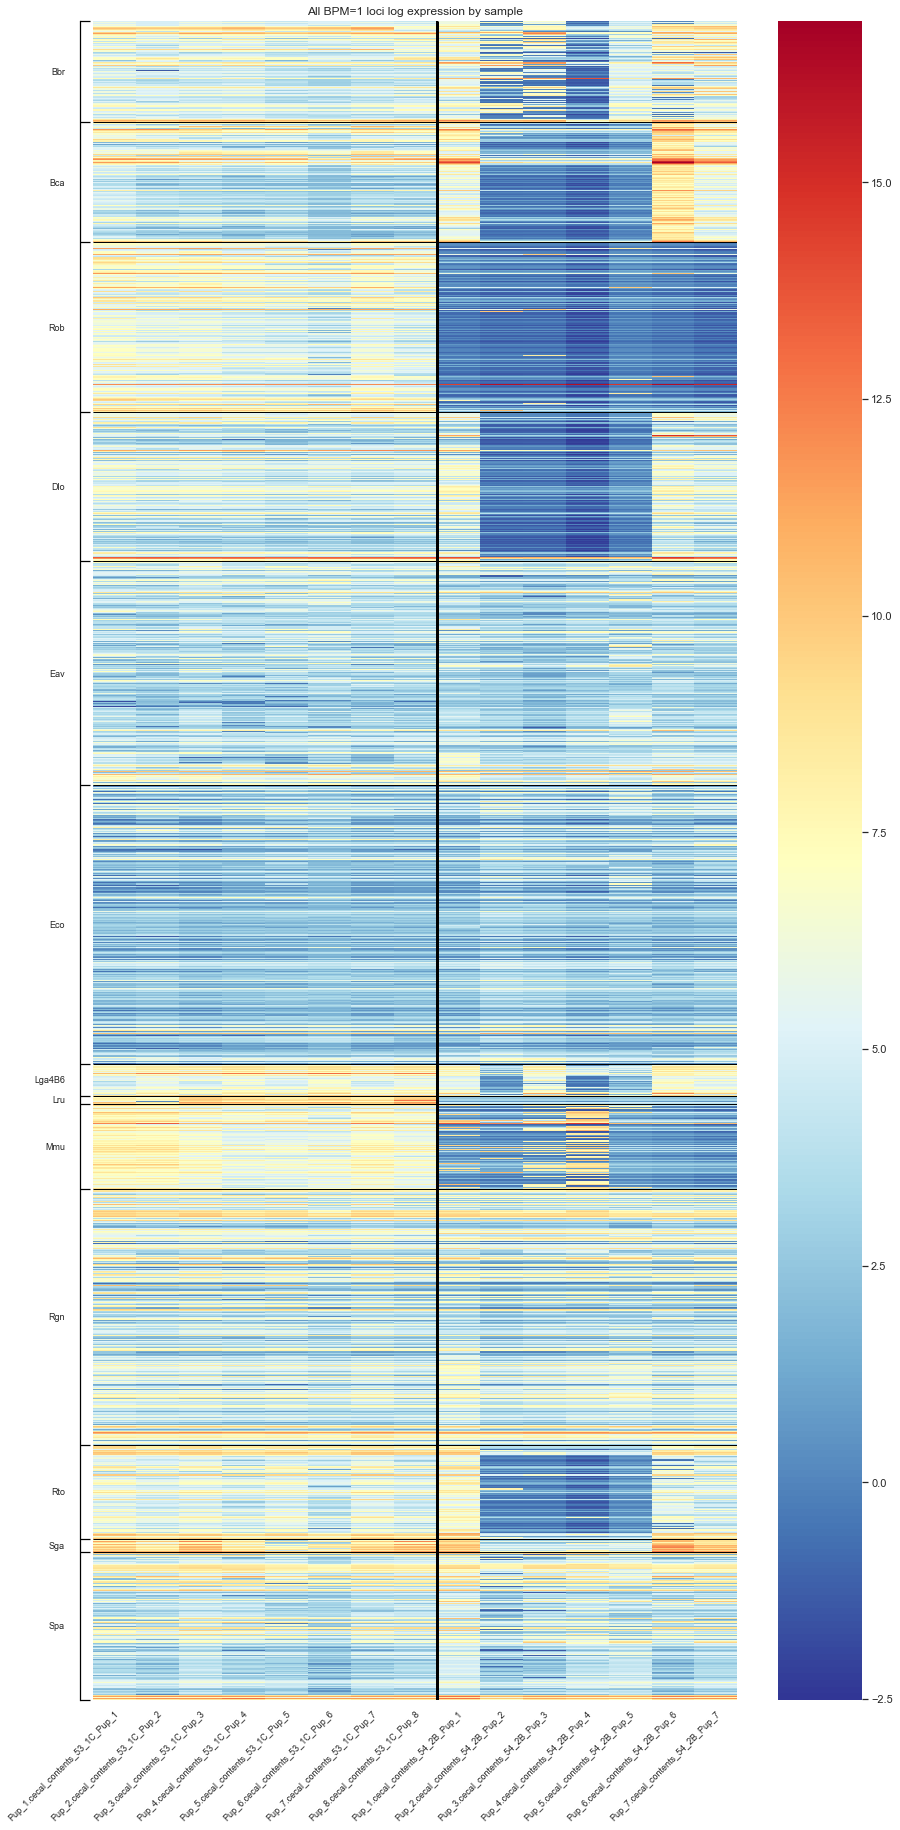

In [9]:
bpm_filt_expr_df = bpm_filter_expr_data(filt_expr_df,bpm_df,mcseed_df)


write_bpm_filt_tables = True
if write_bpm_filt_tables:
    bpm_filt_expr_df.to_csv("{0}/bpm_filt_{1}.csv".format(bpm_filt_dir,DATASET))
    #Write non-na versions of aggregated phenotypes to csv 
#     all_pht_df = pht_aggregation_bpm1(filt_expr_df,bpm_df,mcseed_df,agg_method="agg_method,
#                                  pathway_minimum_fill="min")#log version
    all_pht_df = pht_aggregation_bpm1(filt_expr_df,bpm_df,mcseed_df,agg_method=agg_method,
                                 pathway_minimum_fill="min")#rlog version
 
    min_expr = filt_expr_df.values.min()
    #Drop rows where phenotype expression is min_expr in all samples for condensed_allpht_df 
    condensed_allpht_df = all_pht_df.loc[~(all_pht_df == min_expr).all(axis=1),:] 
    all_pht_df.to_csv("{0}/bpm1_agg_pht_{1}.csv".format(bpm_filt_dir,DATASET)) 
    condensed_allpht_df.to_csv("{0}/condensed_agg_pht_{1}.csv".format(bpm_filt_dir,DATASET))
display(all_pht_df)
    

plot_transcript_heatmap = True
if plot_transcript_heatmap:
#     fig = plt.figure(figsize=(12,18))
    fig, ax1 = plt.subplots(1,1, figsize=(12,24))
    fig.tight_layout()
    plt.title("All BPM=1 loci log expression by sample",fontsize=12)
    sns.set(font_scale=1.0)
    g = sns.heatmap(bpm_filt_expr_df,cmap="RdYlBu_r",xticklabels=True,yticklabels=True,ax=ax1)
    
    bpm_filt_vc_locus_tag = bpm_filt_expr_df.index.str.extract(r'(\w+)_\d+',expand=False).value_counts(sort=False)
#     vc_by_strain_locus_tag.drop("ROSSTS7063_a2",inplace=True)
    bpm_filt_locus_tag_strains = [mcseed_df.loc[mcseed_df.index.str.contains(lt),"Isolate name"].values[0] 
                             for lt in bpm_filt_vc_locus_tag.index] #if lt != "ROSSTS7063_a2"]
    bpm_filt_locus_vc_df = pd.DataFrame(index=bpm_filt_vc_locus_tag.index,columns=["Filtered Loci","Strain"])
    bpm_filt_locus_vc_df.loc[:,"Filtered Loci"] = bpm_filt_vc_locus_tag
    bpm_filt_locus_vc_df.loc[:,"Strain"] = bpm_filt_locus_tag_strains
    bpm_filt_locus_vc_df.set_index("Strain",inplace=True)

    strain_hline_pos, strain_label_pos = [0], []
    for strain,loci_count in bpm_filt_locus_vc_df["Filtered Loci"].iteritems():
        #position is top of block of strain phenotypes; top of heatmap is position 0  
        strain_hline_pos.append((bpm_filt_locus_vc_df["Filtered Loci"].loc[:strain].sum()))
        strain_label_pos.append((bpm_filt_locus_vc_df["Filtered Loci"].loc[:strain].sum())-loci_count/2)
    #hline and vline plotting for cecal-ileal (x-axis), 1C-2A (x-axis), and strain (y-axis) separation
    cecal_ileal_vline = n_1C_cecal + n_2A_cecal
    g.vlines([cecal_ileal_vline],*g.get_ylim(),color="black",linewidth=3)
    arm_vlines = [n_1C_cecal,n_1C_cecal+n_1C_ileal+n_2A_cecal]
    g.vlines(arm_vlines,*g.get_ylim(),color="black",linewidth=2)
    g.hlines(strain_hline_pos[1:-1],*g.get_xlim(),color="black",linewidth=1)
    #Set y-ticks to be strains for block of loci
    g.yaxis.tick_left()
    g.set_yticks(strain_hline_pos)
#     g.minorticks_on()
#     g.tick_params(left=True)
    g.yaxis.set_major_formatter(ticker.NullFormatter())
    g.yaxis.set_minor_locator(ticker.FixedLocator(strain_label_pos))
    g.yaxis.set_minor_formatter(ticker.FixedFormatter([STRAIN_TAGS[strain] for strain in bpm_filt_locus_vc_df.index]))
    g.tick_params(axis='y',which='minor', length=0,pad=15,labelsize=9,color="black")
    g.tick_params(axis='y',which='major',length=10,direction="in",color="black") 
    g.spines.left.set_color('black')
    g.spines.left.set_position(("axes",-.02))
    g.spines.left.set_visible('black')
    
    g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right', rotation_mode='anchor',fontsize=9)
    g.set_facecolor("#C0C0C0")
    plt.savefig("{0}/bpm1_transcripts_{1}.pdf".format(figures_dir,DATASET), dpi=200, facecolor='w',bbox_inches="tight")

(array([2.070e+02, 7.020e+02, 1.697e+03, 2.097e+03, 2.308e+03, 2.316e+03,
        3.419e+03, 4.129e+03, 5.112e+03, 5.534e+03, 5.454e+03, 5.320e+03,
        5.068e+03, 4.196e+03, 3.359e+03, 2.426e+03, 1.777e+03, 1.355e+03,
        9.250e+02, 6.710e+02, 3.700e+02, 2.220e+02, 1.300e+02, 6.500e+01,
        4.400e+01, 1.300e+01, 9.000e+00, 3.000e+00, 4.000e+00, 3.000e+00]),
 array([-2.50596783, -1.86039061, -1.21481339, -0.56923618,  0.07634104,
         0.72191826,  1.36749547,  2.01307269,  2.6586499 ,  3.30422712,
         3.94980434,  4.59538155,  5.24095877,  5.88653599,  6.5321132 ,
         7.17769042,  7.82326764,  8.46884485,  9.11442207,  9.75999929,
        10.4055765 , 11.05115372, 11.69673094, 12.34230815, 12.98788537,
        13.63346259, 14.2790398 , 14.92461702, 15.57019424, 16.21577145,
        16.86134867]),
 <BarContainer object of 30 artists>)

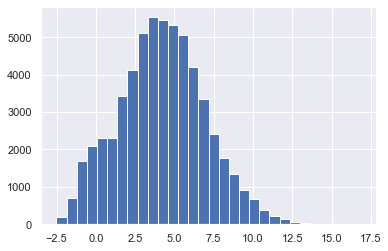

In [10]:
plt.hist(bpm_filt_expr_df.values.flatten(),bins=30)

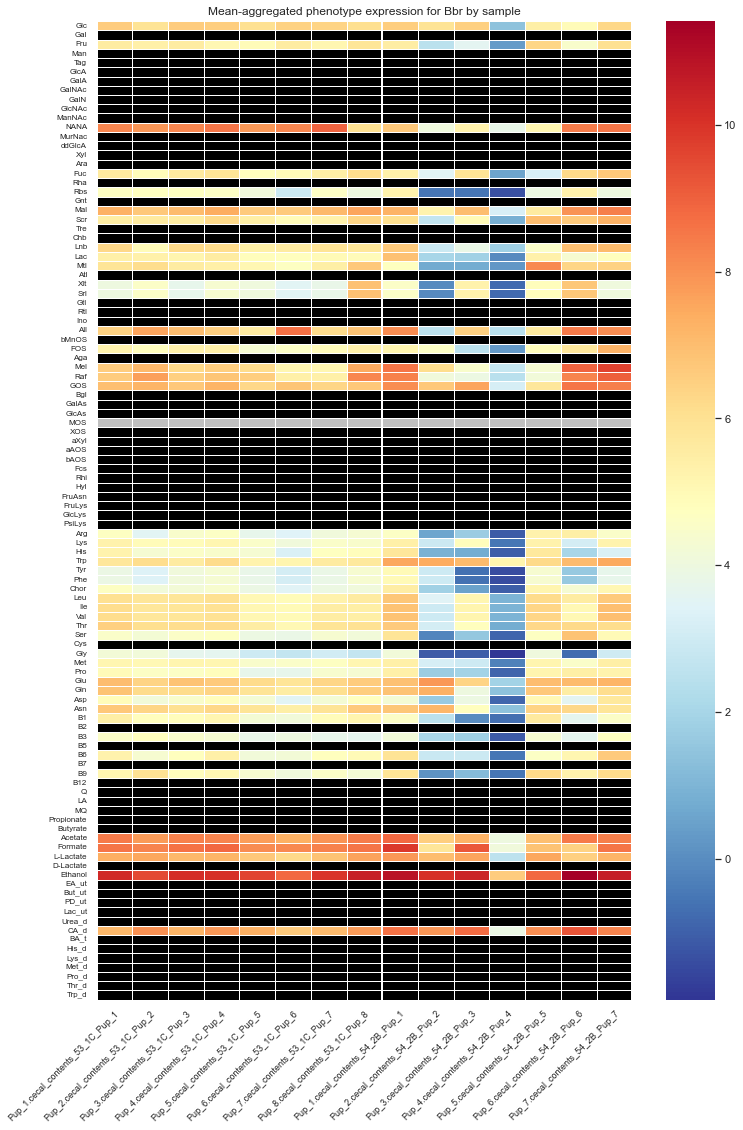

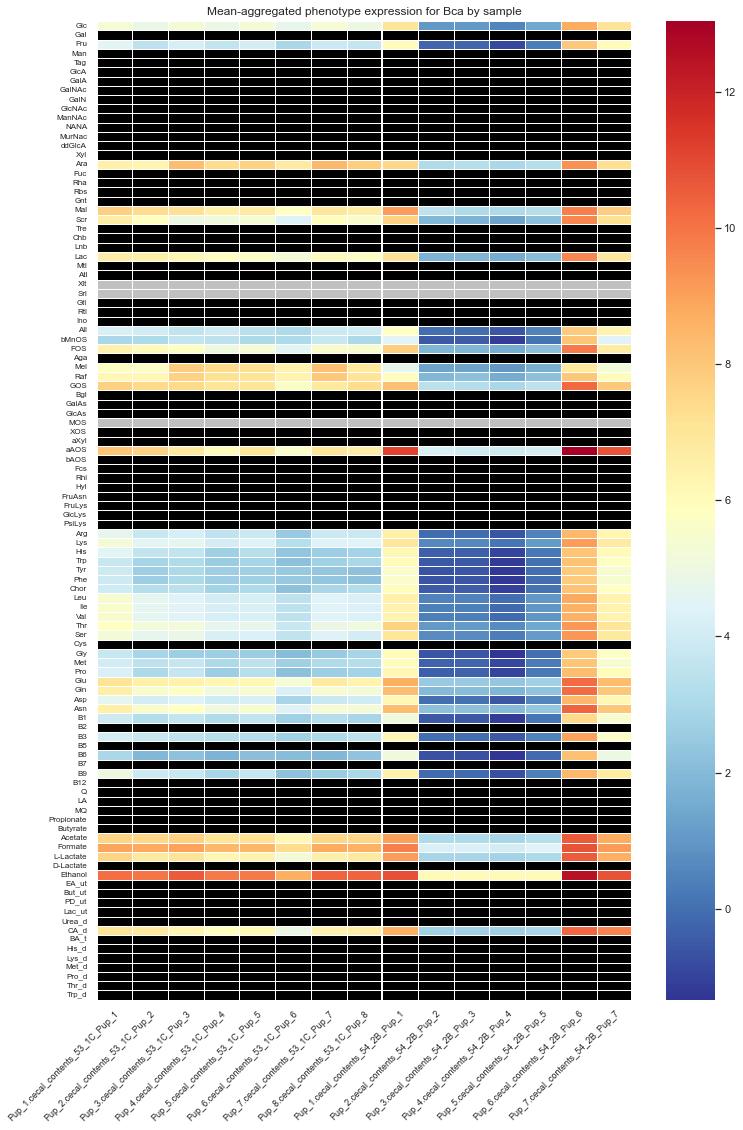

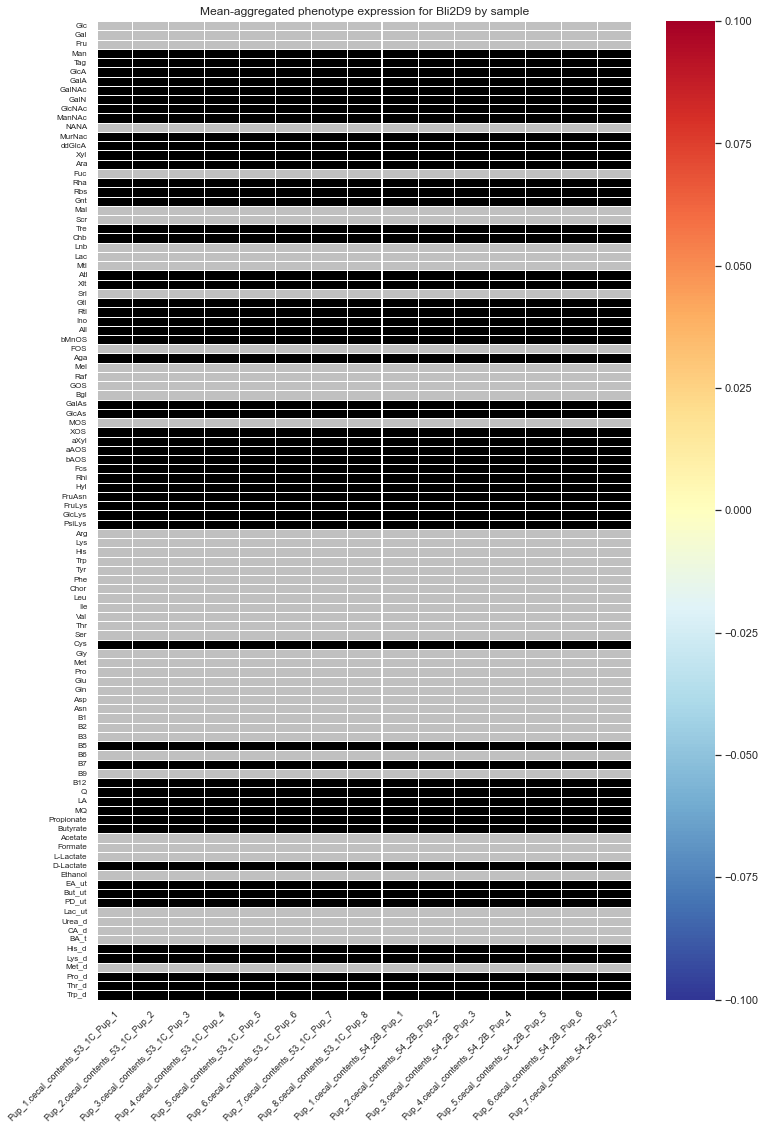

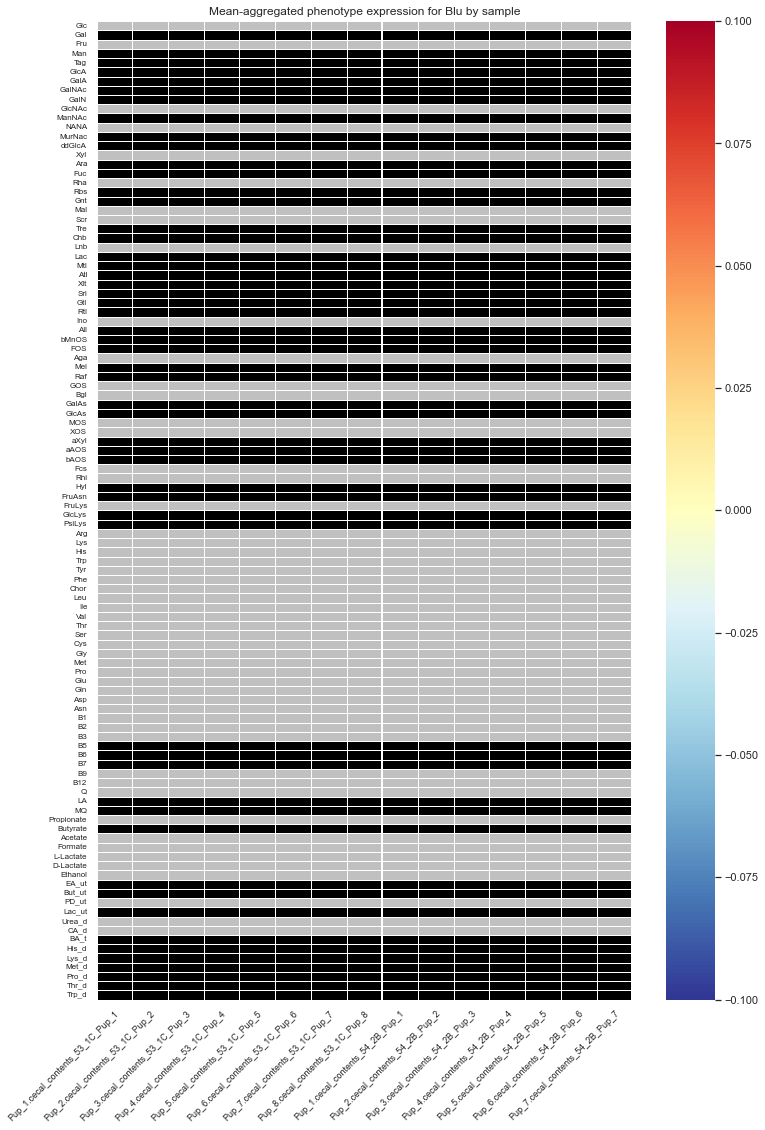

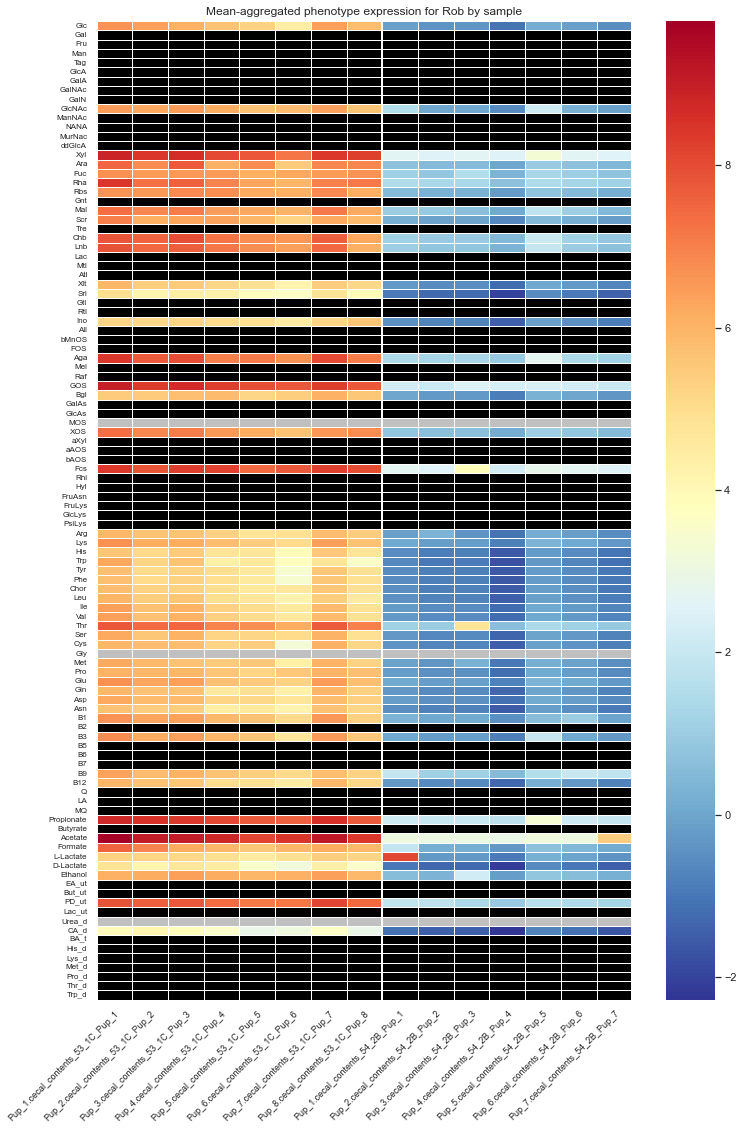

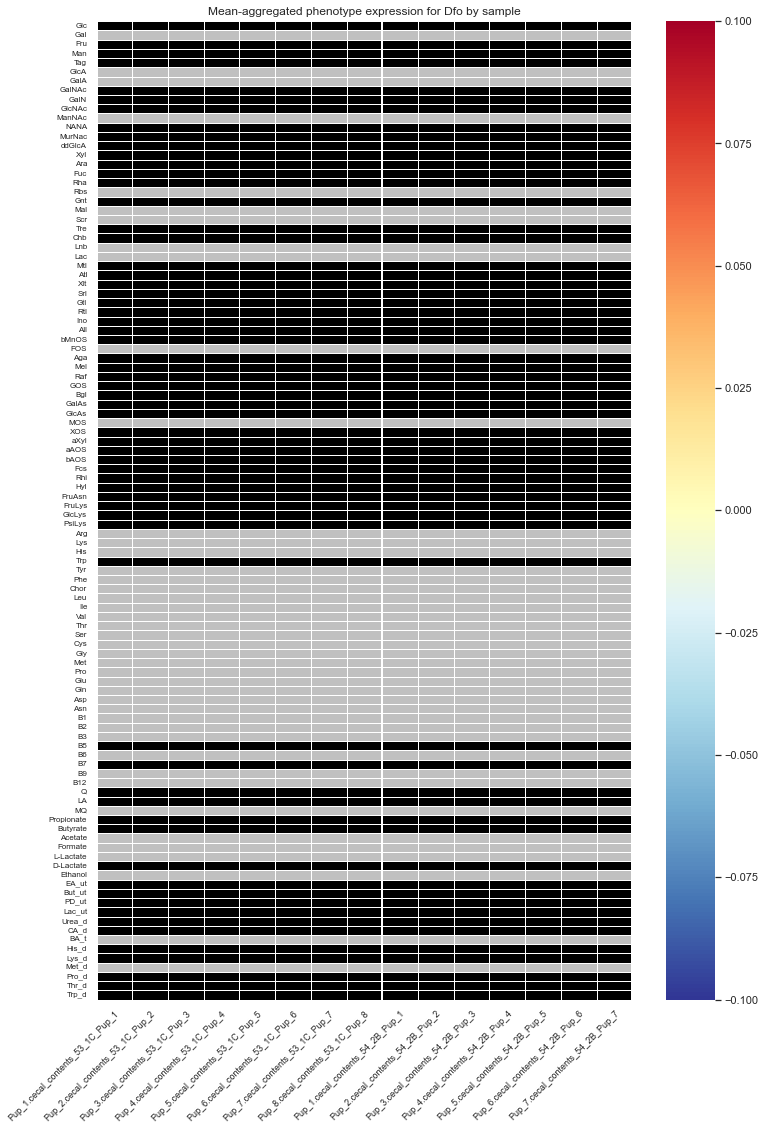

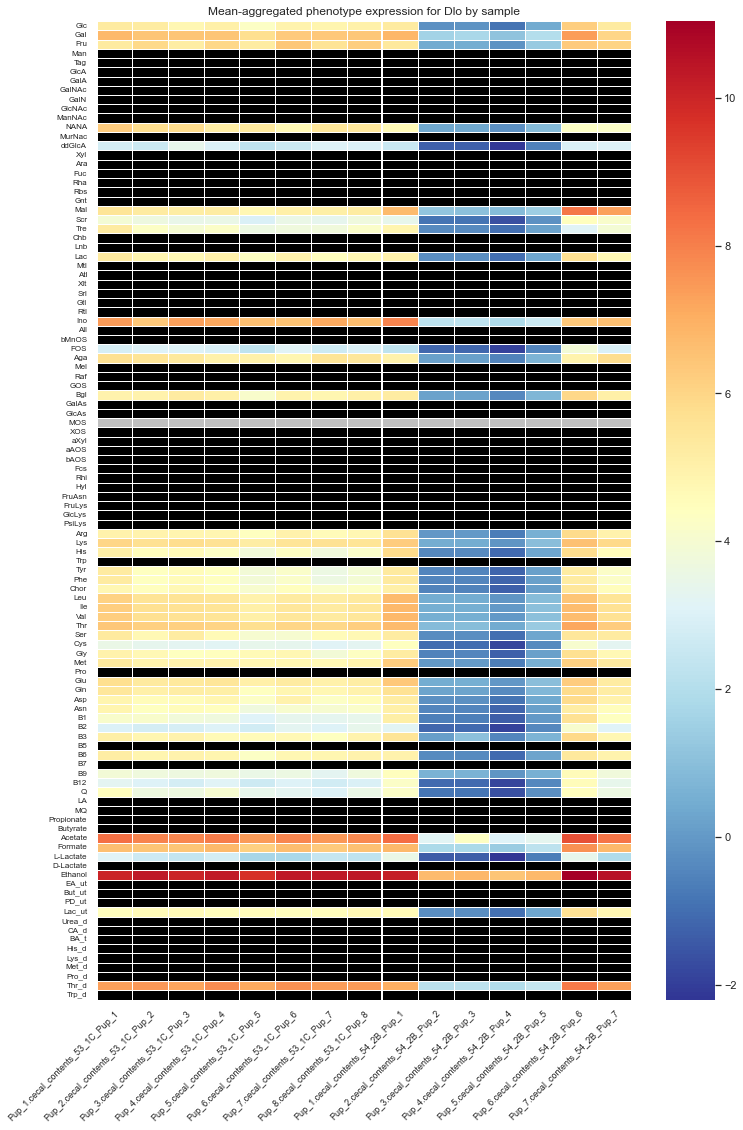

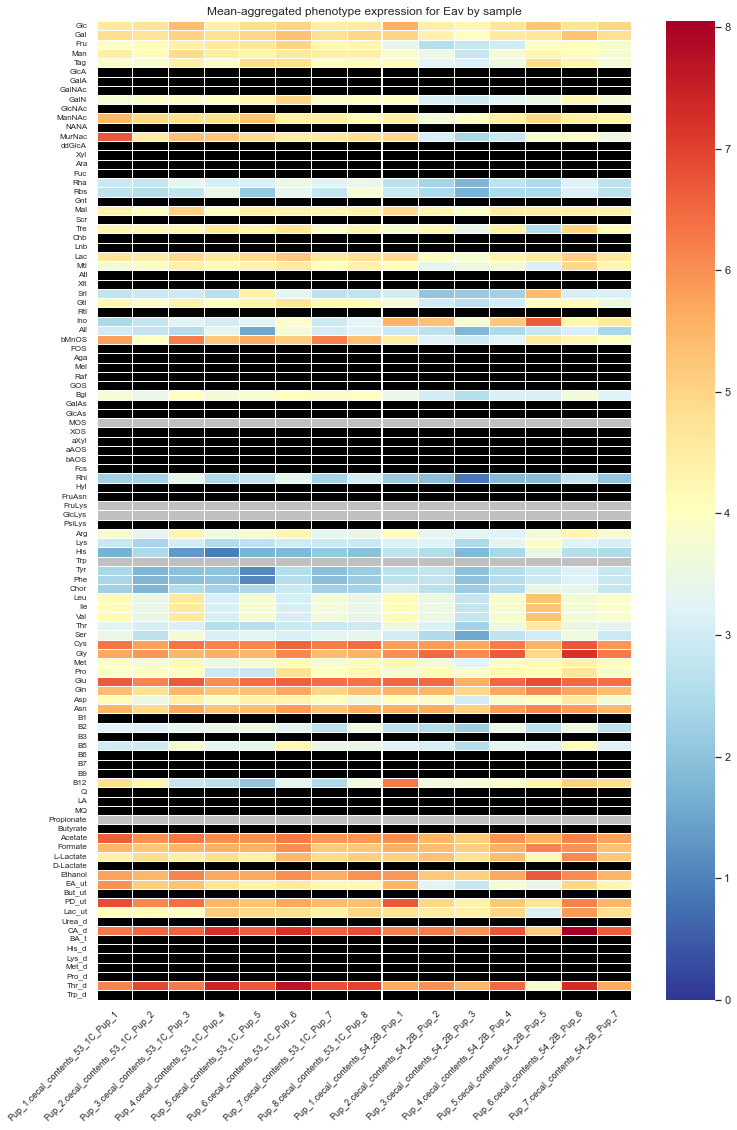

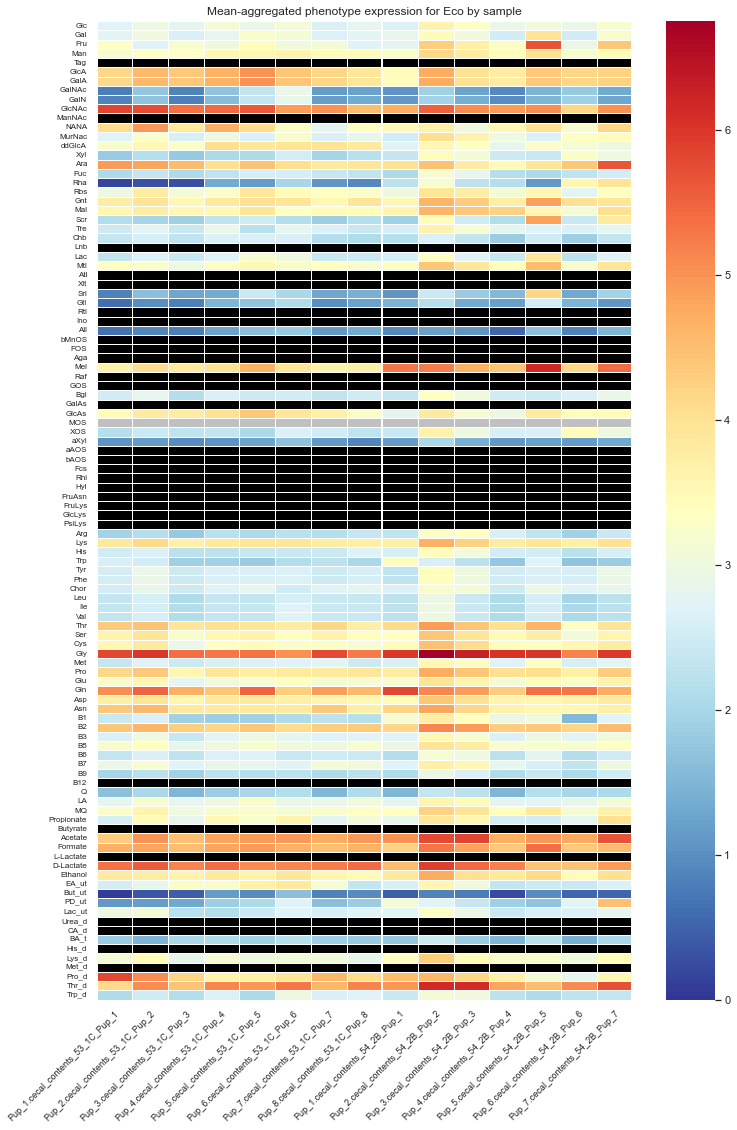

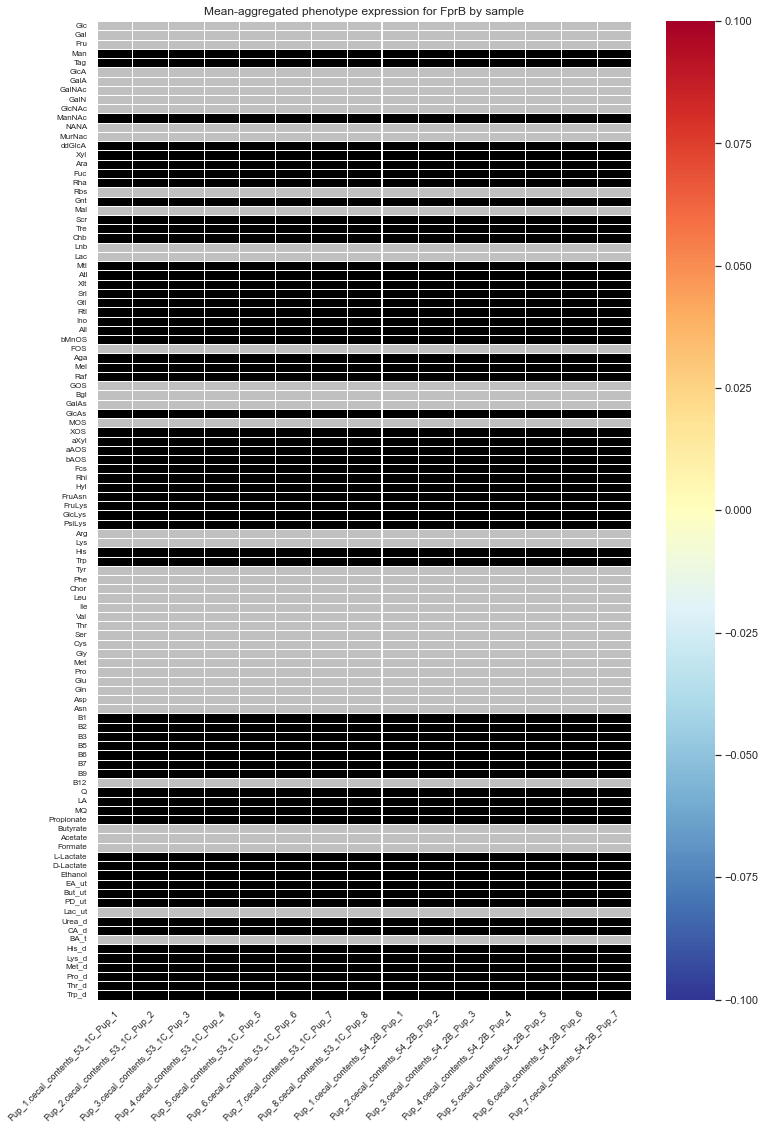

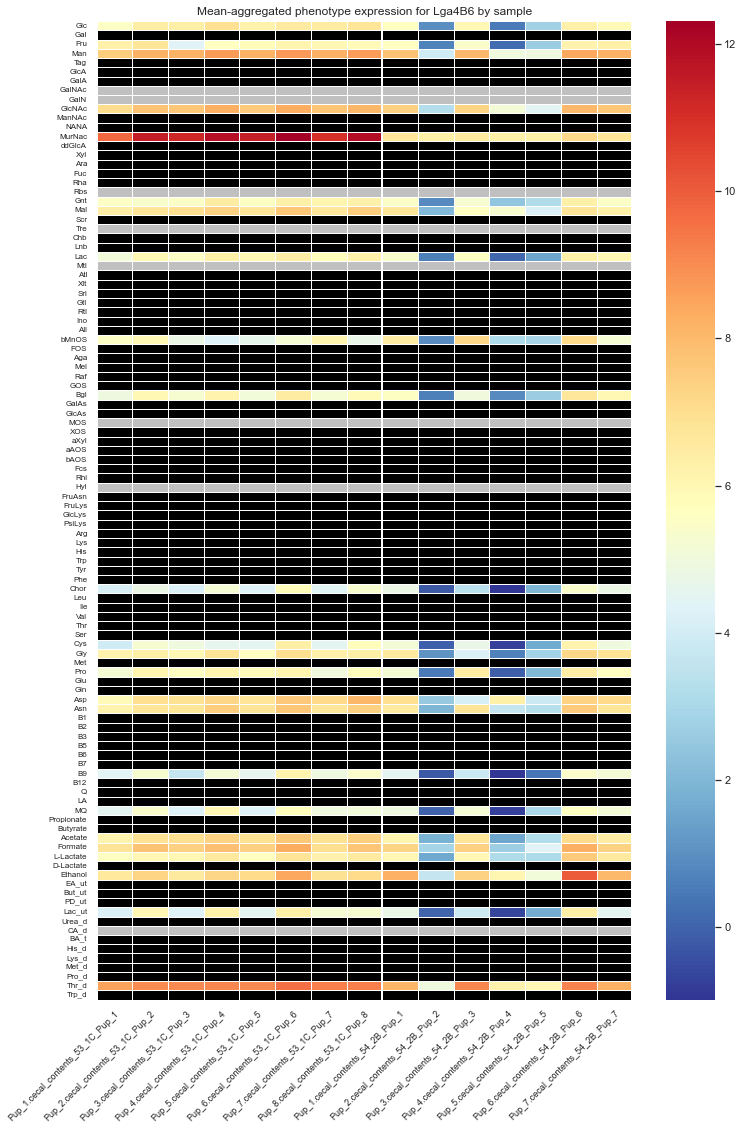

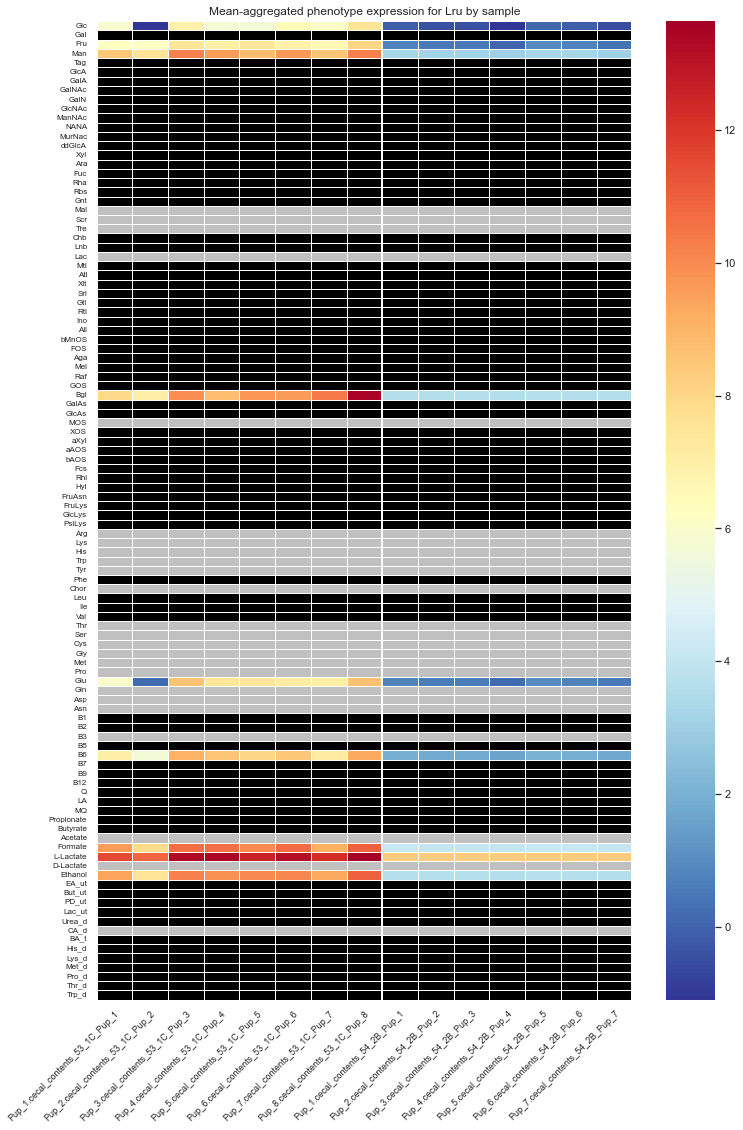

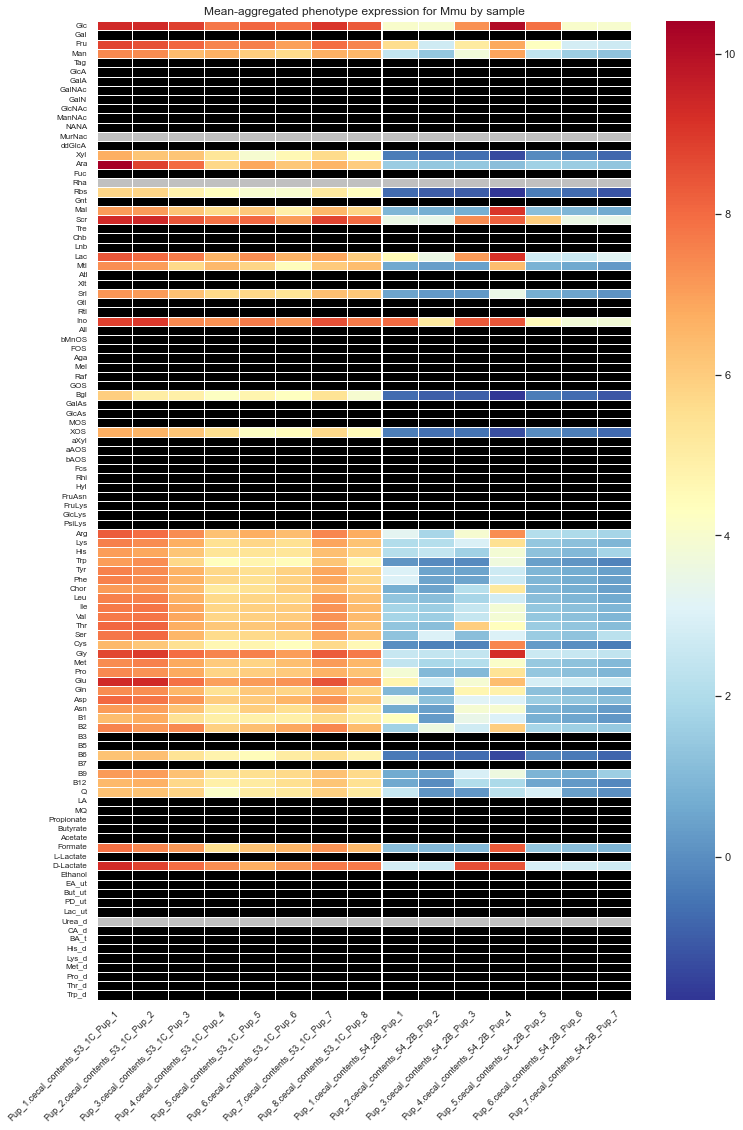

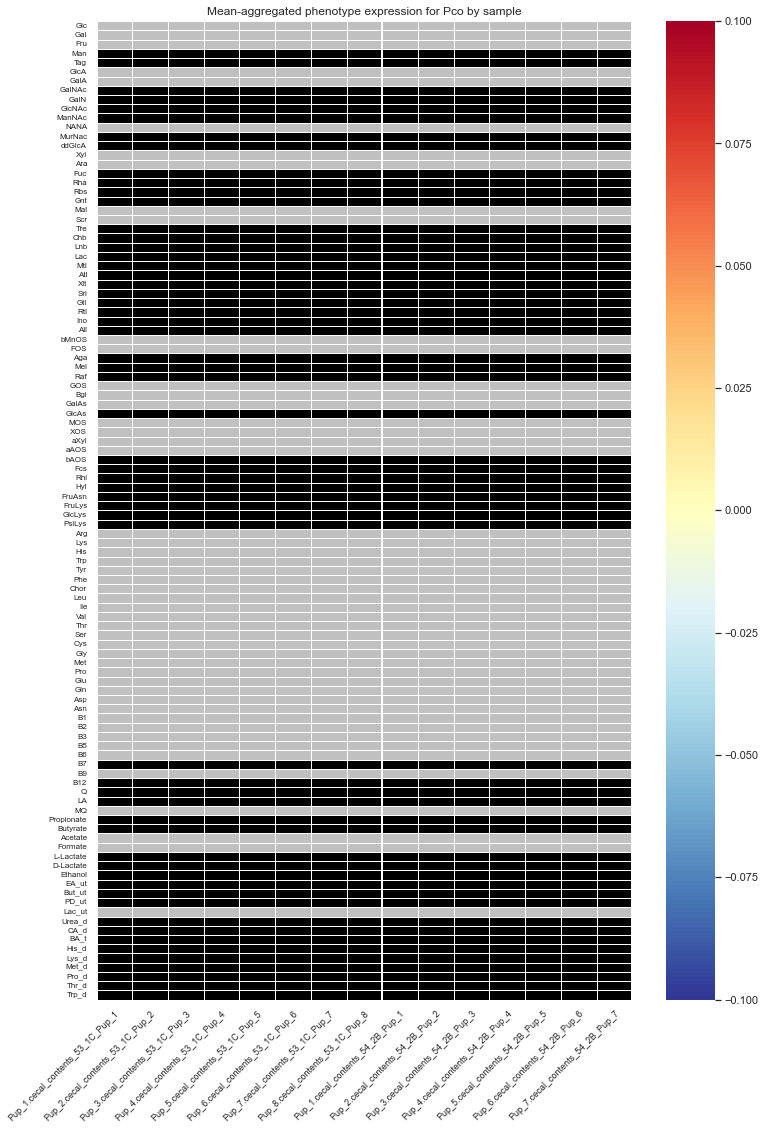

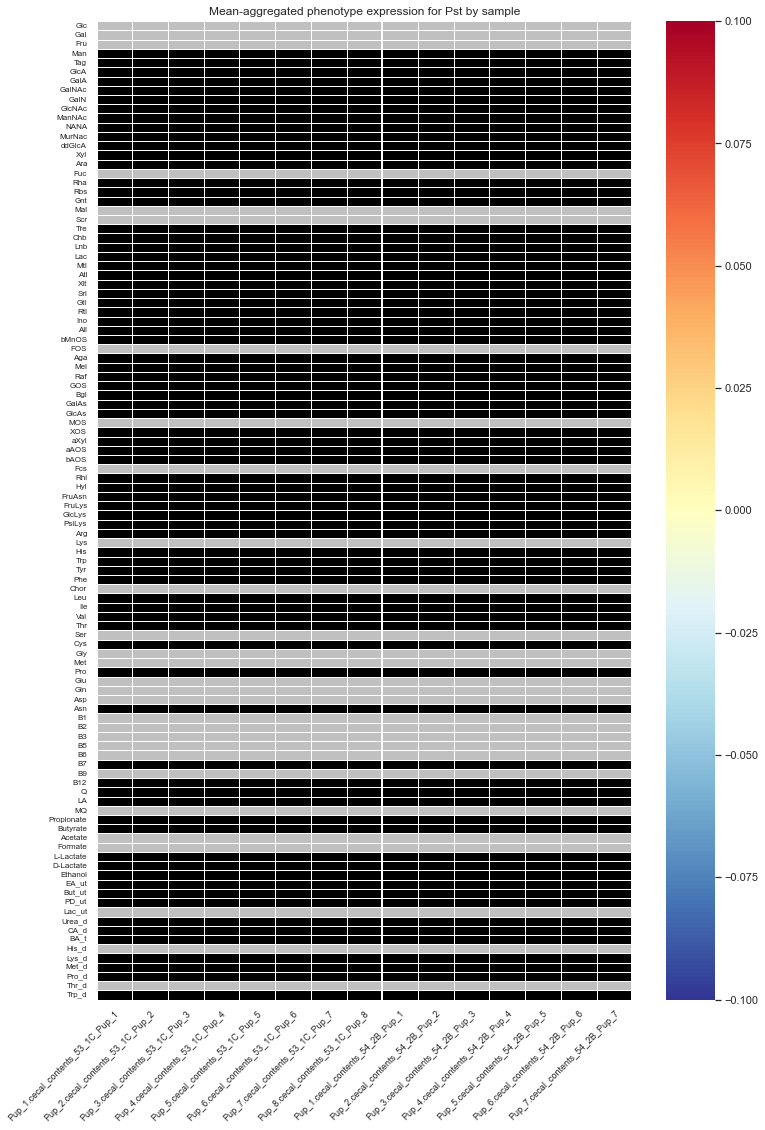

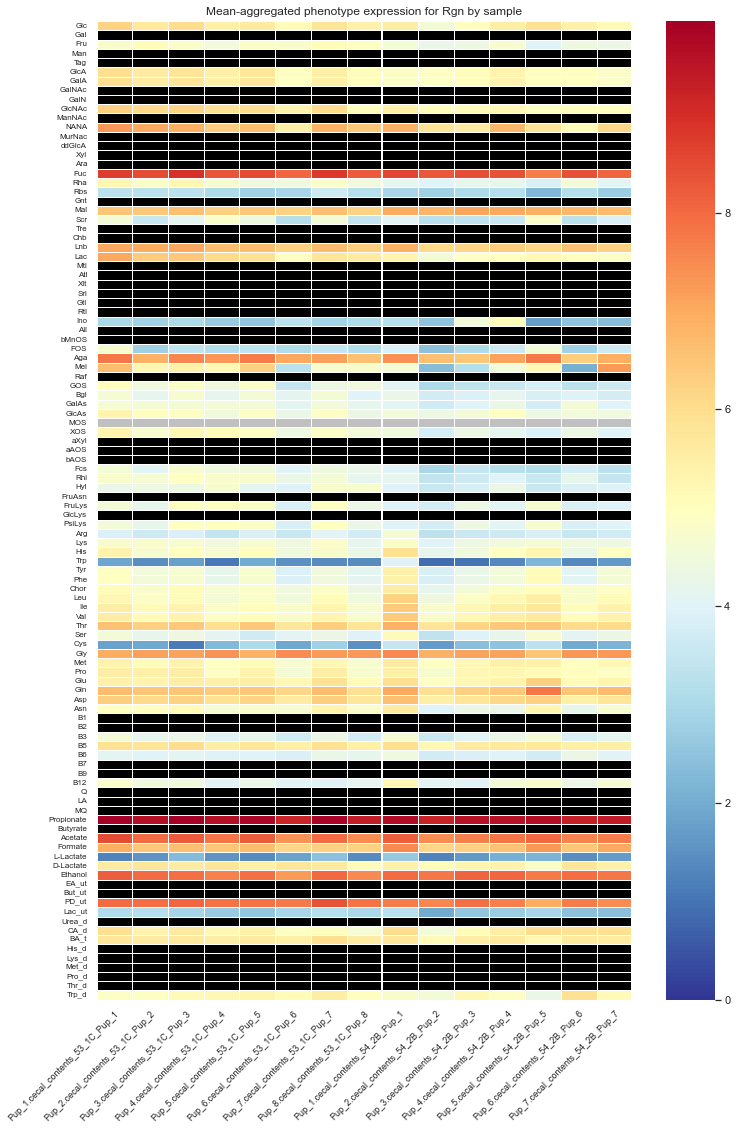

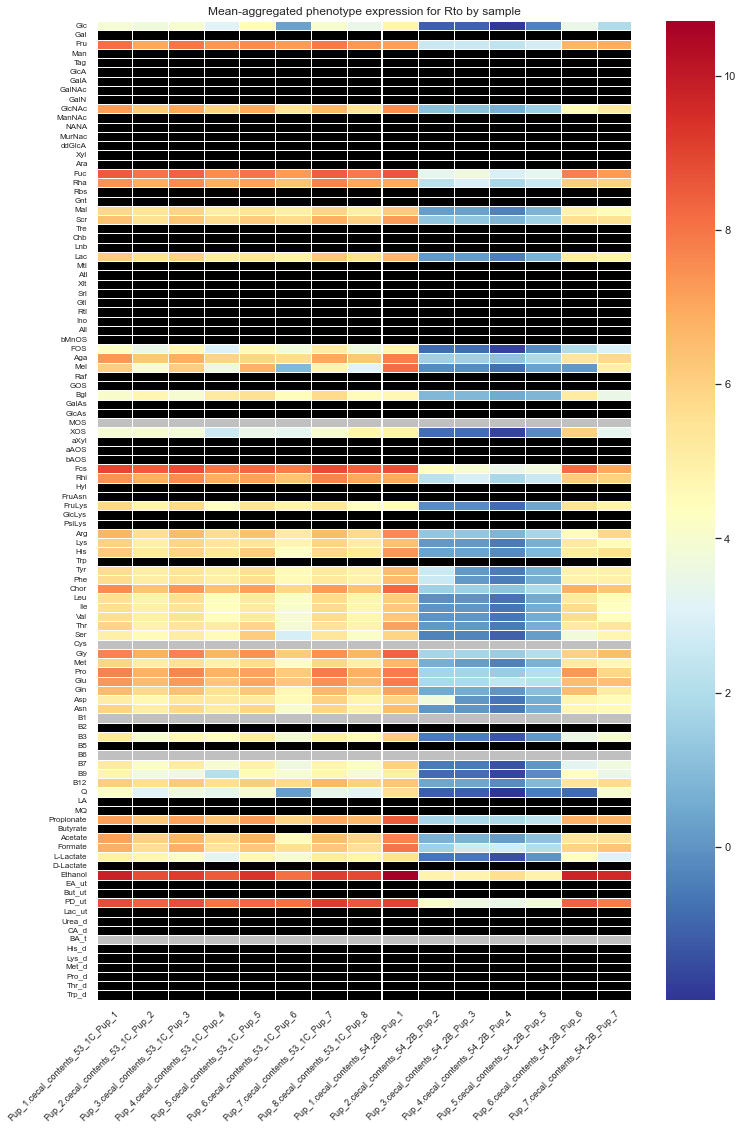

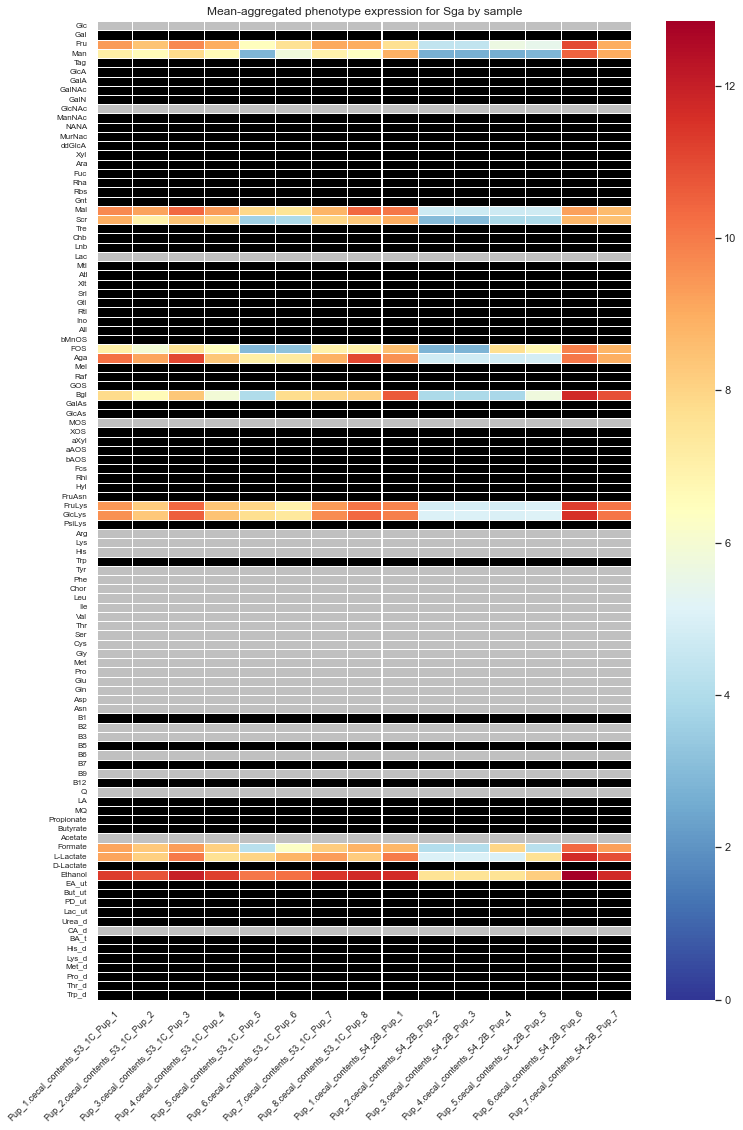

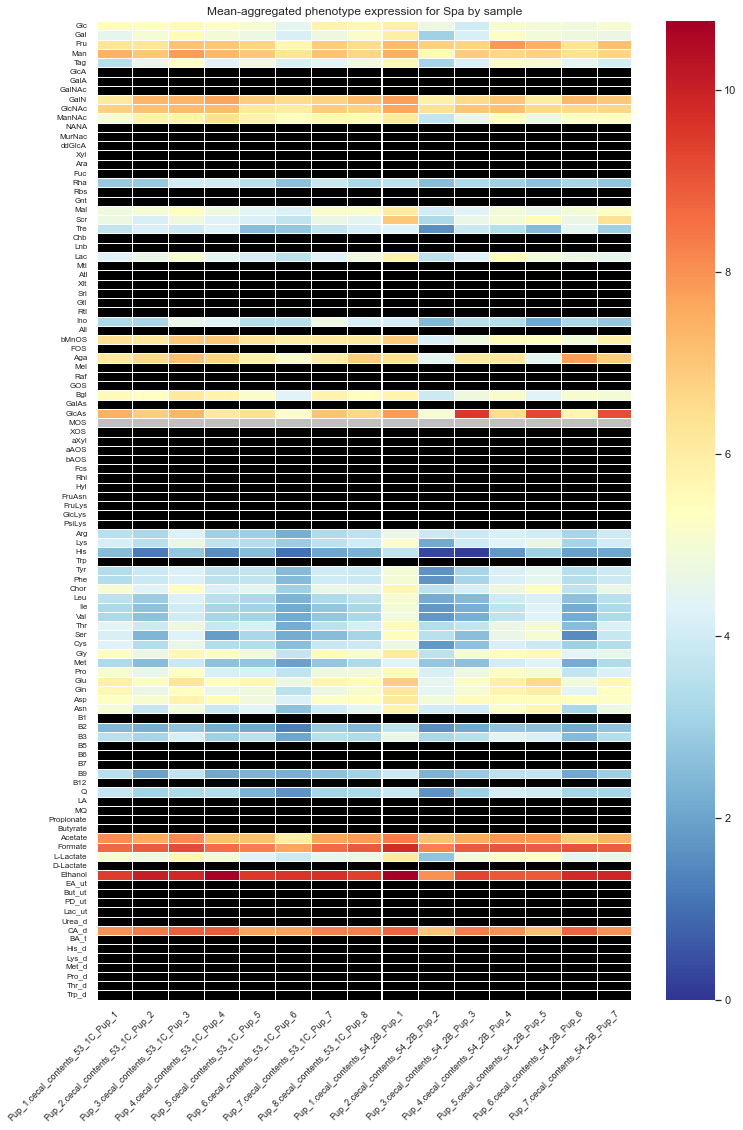

In [11]:
#tpm based sample pht aggregation dataframes 
#sample_pht_expr_dfs = per_sample_pht_aggregation(tpm_df,bpm_df,mcseed_df)

#Sample_pht_aggregation dataframes 
sample_pht_expr_dfs = per_sample_pht_aggregation(filt_expr_df,bpm_df,mcseed_df,agg_method="mean")

#Use sample_pht_expr_dfs to construct phenotype x sample heatmaps for each strain
#Mostly exploratory analysis - assess which strains have phenotype aggregated signal that is 1) present and 
#2) differentiates the Pco and no Pco arms (in cecal and/or ileal samples)

strain_pht_expr_index, strain_pht_expr_cols = bpm_df.index, filt_expr_df.columns
strain_figs = "{0}/strains/{1}".format(figures_dir,DATASET)
if not os.path.exists(strain_figs):
    os.makedirs(strain_figs)

for strain in STRAIN_TAGS:
    strain_abbrev = STRAIN_TAGS[strain]
    strain_sample_pht_expr_df = pd.DataFrame(index=strain_pht_expr_index,columns=strain_pht_expr_cols)

    for sample in sample_pht_expr_dfs: 
        sample_pht_expr_df = sample_pht_expr_dfs[sample]
        strain_sample_pht_expr_df.loc[:,sample] = sample_pht_expr_df.loc[:,strain]
#     display(strain_sample_pht_expr_df)

    #Reorder columns by 1: cecal contents then ileal; 2: Study Arm (1C = Pre-weaning Pco vs 2B = No Pco)
    cols_1C_arr, cols_2B_arr = [strain_sample_pht_expr_df.columns.str.contains(tag) for tag in ["1C","2B"]] #boolean arrays 
    cols_1C, cols_2B = [strain_sample_pht_expr_df.columns[cols] for cols in [cols_1C_arr,cols_2B_arr]]#filtered column lists 
    cols_1C_cecal_arr, cols_1C_ileal_arr = [cols_1C.str.contains(tag) for tag in ["cecal","ileal"]] #boolean_arrays
    cols_1C_cecal, cols_1C_ileal = [cols_1C[cols_1C_cecal_arr],cols_1C[cols_1C_ileal_arr]] #filtered columns
    cols_2B_cecal_arr, cols_2B_ileal_arr = [cols_2B.str.contains(tag) for tag in ["cecal","ileal"]] #boolean arrays
    cols_2B_cecal, cols_2B_ileal = [cols_2B[cols_2B_cecal_arr],cols_2B[cols_2B_ileal_arr]]
    n_1C_cecal, n_1C_ileal, n_2B_cecal, n_2B_ileal = [len(cols) for cols in [cols_1C_cecal,cols_1C_ileal,
                                                                            cols_2B_cecal,cols_2B_ileal]]
    reordered_cols = pd.Index(list(cols_1C_cecal)+list(cols_2B_cecal)+list(cols_1C_ileal)+list(cols_2B_ileal))
    strain_sample_pht_expr_df = strain_sample_pht_expr_df.loc[:,reordered_cols]

    strain_pht_heatmap_mask = pd.DataFrame(index=strain_sample_pht_expr_df.index, columns=strain_sample_pht_expr_df.columns)
    strain_pht_heatmap_mask.loc[:,:] = False
    strain_pht_heatmap_mask.loc[bpm_df.loc[:,strain]==True,:] = True

#     display(strain_pht_heatmap_mask)

    fig = plt.figure(figsize=(12,18))
    fig.tight_layout()
    plt.title("Mean-aggregated phenotype expression for {0} by sample".format(strain_abbrev),fontsize=12)
    sns.set(font_scale=1.0)

    g = sns.heatmap(strain_sample_pht_expr_df,cmap="RdYlBu_r",linewidths=.5,xticklabels=True,yticklabels=True)
    #Black-mask BPM negative rows using strain_pht_heatmap_mask
    g2= sns.heatmap(strain_pht_heatmap_mask.astype(int),cmap="Greys",vmin=-1,vmax=0,mask=strain_pht_heatmap_mask,
                    linewidths=0.5,cbar=False,yticklabels=True)
    cecal_ileal_vline = n_1C_cecal + n_2B_cecal
    g.vlines([cecal_ileal_vline],*g.get_ylim(),color="white",linewidth=3)
    arm_vlines = [n_1C_cecal,n_1C_cecal+n_1C_ileal+n_2B_cecal]
    g.vlines(arm_vlines,*g.get_ylim(),color="white",linewidth=2)
    g.set_yticklabels(g.get_yticklabels(),fontsize =8)
    g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right', rotation_mode='anchor',fontsize=9)
    # g.set_facecolor("#FFFFFF")
    g.set_facecolor("#C0C0C0")

    plt.savefig("{0}/{1}_sample_heatmap_filt_{2}.pdf".format(strain_figs,strain_abbrev,DATASET),
                dpi=200, facecolor='w',bbox_inches="tight")


In [20]:
#BPM1 filter counts data for downstream edgeR
filt_count_fpath = "{0}/filt_merged_count.csv".format(transformed_data_dir)
filt_count_df = pd.read_csv(filt_count_fpath,index_col=0)

bpm_filt_count_df = bpm_filter_expr_data(filt_count_df,bpm_df,mcseed_df)
bpm_filt_count_df.index.name = "target_id"
bpm_filt_count_df.drop_duplicates(inplace=True)

# bpm_filt_dir = "formatted_output/4th_trial/bpm_filtered/{0}".format(param_str)
bpm_filt_dir = "formatted_output/4th_trial/bpm_filtered_abundance_corrected/{0}".format(param_str)
if not os.path.exists(bpm_filt_dir):
    os.makedirs(bpm_filt_dir)
    
bpm_filt_count_df.to_csv("{0}/bpm_filt_count.csv".format(bpm_filt_dir))

In [21]:
print(len(bpm_filt_count_df.index.unique()))
display(bpm_filt_count_df.index.value_counts())
display(bpm_filt_count_df.loc["LDOIJNDB_00590",:])

2046


ANCJAENF_00282    1
ONMCJBAG_01411    1
ONMCJBAG_00832    1
ONMCJBAG_01970    1
ONMCJBAG_01969    1
                 ..
OOAPABDJ_01082    1
OOAPABDJ_00569    1
OOAPABDJ_02608    1
OOAPABDJ_01895    1
LDOIJNDB_00003    1
Name: target_id, Length: 2046, dtype: int64

Pup_1.cecal_contents_53_1C_Pup_1    1775.0
Pup_2.cecal_contents_53_1C_Pup_2    3483.0
Pup_3.cecal_contents_53_1C_Pup_3    1579.0
Pup_4.cecal_contents_53_1C_Pup_4     493.0
Pup_5.cecal_contents_53_1C_Pup_5     356.0
Pup_6.cecal_contents_53_1C_Pup_6      76.0
Pup_7.cecal_contents_53_1C_Pup_7     597.0
Pup_8.cecal_contents_53_1C_Pup_8     518.0
Pup_1.cecal_contents_54_2B_Pup_1    1706.0
Pup_2.cecal_contents_54_2B_Pup_2     715.0
Pup_3.cecal_contents_54_2B_Pup_3    1116.0
Pup_4.cecal_contents_54_2B_Pup_4    4649.0
Pup_5.cecal_contents_54_2B_Pup_5     402.0
Pup_6.cecal_contents_54_2B_Pup_6     652.0
Pup_7.cecal_contents_54_2B_Pup_7    1343.0
Name: LDOIJNDB_00590, dtype: float64